# Poço Quadrado Finito

## Bibliotecas utilizadas

In [3]:
# python standard
import time

# third-party
import numpy as np
import scipy.constants as cte
from scipy.integrate import simps
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.optimize import newton

## Configurações gráficas

In [5]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

## Classe que simula um poço

In [11]:
class PocoQuantico(object):
    """Simula um poço quântico"""


    def __init__(self, well_length=100.0, well_height=1.0, N=2048, 
            dt=1e-19, surround=1):
        """Construtor
        
        Parametros
        ----------
        well_length : float
            a largura do poço em angstrom
        well_height: float
            a altura do poço em eV
        N : int
            o número de pontos para a malha espacial
        dt : float
            o passo de tempo em segundos
        surround : int
            quantas vezes a largura do poço é utilizada para formar as
            barreiras. Por exemplo, para um poço de largura
            100.0 Angstrom, surround=1 significa que será adicionado ao
            sistema mais 100.0 Angstrom de cada lado, constituindo um
            sistema de largura total 300.0 Angstrom. Para o mesmo poço,
            surround=2, seria adicionado ao sistema 200.0 Angstrom de
            cada lado, totalizando um sistema de 500.0 Angstrom
        """

        # unidades atômicas
        self.au_l = cte.value('atomic unit of length')
        self.au_t = cte.value('atomic unit of time')
        self.au_e = cte.value('atomic unit of energy')

        # outras constantes de interesse
        self.ev = cte.value('electron volt')
        self.au2ang = self.au_l / 1e-10
        self.au2ev = self.au_e / self.ev

        # massa efetiva constante
        self.m_eff = 1.0

        # cria um dispositivo
        self.set_device(well_length, well_height, N, dt, surround)

    def set_device(self, well_length=100.0, well_height=1.0, N=2048, 
            dt=(1e-19), surround=1):
        """Ajusta as propriedades do dispositivo mesmo depois de criado
        
        Parametros
        ----------
        well_length : float
            a largura do poço em angstrom
        well_height: float
            a altura do poço em eV
        N : int
            o número de pontos para a malha espacial
        dt : float
            o passo de tempo em segundos
        surround : int
            quantas vezes a largura do poço é utilizada para formar as
            barreiras. Por exemplo, para um poço de largura
            100.0 Angstrom, surround=1 significa que será adicionado ao
            sistema mais 100.0 Angstrom de cada lado, constituindo um
            sistema de largura total 300.0 Angstrom. Para o mesmo poço,
            surround=2, seria adicionado ao sistema 200.0 Angstrom de
            cada lado, totalizando um sistema de 500.0 Angstrom
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """
        self.well_length = W = well_length
        self.well_height = well_height
        self.vb_au = well_height / self.au2ev
        self.wl_au = well_length / self.au2ang
        
        self.device_length = L = (1.0 + 2.0 * surround) * well_length
        self.N = N
        self.z_ang = np.linspace(-L/2.0, L/2.0, self.N)
        self.z_au = self.z_ang / self.au2ang
        self.dz_au = np.abs(self.z_au[1] - self.z_au[0])

        potential = np.vectorize(lambda z: 0.0 if np.abs(z) < W/2 
            else well_height)
        self.v_ev = potential(self.z_ang)
        self.v_au = self.v_ev / self.au2ev

        # ajusta o passo de tempo
        return self._set_time(dt)
    
    def solucao_analitica(self):
        """Calcula os estados ligados do sistema resolvendo as
        equações transcendentais
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """
        import warnings
        warnings.filterwarnings('error')
        eigenvalues = []
        
        # tan(k_w . L / 2) = k_b / k_w
        # cot(k_w . L / 2) = - k_b / k_w
        trans_tan = lambda e: np.tan(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            ) - np.sqrt(self.vb_au/e - 1.0)

        trans_tan_der = lambda e: 1.0 / np.cos(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            )**2 * (
                self.m_eff * self.wl_au / (2 * np.sqrt(2*self.m_eff*e))
            ) + self.vb_au / (2.0 * e**2 * np.sqrt(self.vb_au/e - 1.0))

        trans_cot = lambda e: 1.0 / np.tan(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            ) + np.sqrt(self.vb_au/e - 1.0)

        trans_cot_der = lambda e: -1.0 / np.sin(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            )**2 * (
                self.m_eff * self.wl_au / (2 * np.sqrt(2*self.m_eff*e))
            ) - self.vb_au / (2.0 * e**2 * np.sqrt(self.vb_au/e - 1.0))

        t_functions = [
            (trans_tan,trans_tan_der),
            (trans_cot, trans_cot_der)
        ]

        # chutes de energia iniciais
        energies = np.linspace(-0.1*self.vb_au, 1.1*self.vb_au, 10000)
        
        for f,fp in t_functions:
            for e0 in energies:
                try:
                    root = newton(f, x0=e0, fprime=fp)
                    if root > 0:
                        eigenvalues.append(root * self.au2ev)
                except:
                    pass
                    
        eigenvalues = np.array(list(sorted(set(eigenvalues))))
        
        # os autovalores neste momento estão em uma grande list com
        # 2000 elementos, muitos são repetidos, devido aos chutes
        # iniciais próximos convergirem para o mesmo resultado
        # o algoritmo abaixo identifica aqueles que estão em um
        # intervalo muito próximo
        offset = [0]
        for i in range(1, eigenvalues.size):
            if np.abs(eigenvalues[i] / \
                    np.average(eigenvalues[offset[-1]:i])-1.0) > 0.01:
                offset.append(i)
        offset.append(len(eigenvalues))
        eigenvalues = [np.average(eigenvalues[offset[i]:offset[i+1]]) \
            for i in range(len(offset)-1)]
        return eigenvalues

    def evolucao_imaginaria(self, nmax=None, precision=1e-4, 
            iterations=None, max_time=None, reset=False):
        """CCalcula os estados ligados do sistema utilizando um método
        numérico (Pseudo-Espectral: Split-Step FFT)
        
        Parâmetros
        ----------
        nmax : int
            o número de estados ligados a serem gerados
        precision : float
            a precisão numérica aceita
        iterations : int
            o número máximo de iterações
        max_time : float
            o tempo máximo de processamento por nível de energia
        reset : boolean
            se verdadeiro, reinicia o sistema, caso contrário continua
            evoluindo um sistema que já começou a ser evoluído
            anteriormente, mas que foi interrompido por, por exemplo,
            ultrapassa o número máximo de iterações
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """

        # seleciona o modo tempo imaginário
        self._set_time(imaginary=True)
        analytic_values = self.solucao_analitica()
        if nmax:
            nmax = min(nmax, len(analytic_values))
        else:
            nmax = len(analytic_values)

        if reset or not hasattr(self, 'eigenvalues'):
            # inicializa os autovalores como zero
            self.eigenvalues = np.zeros(nmax)
            short_grid = np.linspace(-1, 1, self.N)

            # inicializa os autovetores como polinômios de legendre
            # multiplicados por uma gaussiana
            g = gaussian(self.N, std=int(self.N/100))
            self.eigenstates = np.array([g*legendre(i)(short_grid) 
                for i in range(nmax)],dtype=np.complex_)
            
            # os contadores vão armazenar o máximo de iterações por
            # estado
            self.counters = np.zeros(nmax, dtype=np.int32)

            # os timers vão salvar o tempo que cada estado leva
            self.timers = np.zeros(nmax)

            # salva a precisão obtida em cada autoestado
            self.eigenvalues_precisions = np.zeros(nmax)

            # salva a precisão obtida em cada autovalor
            self.eigenstates_precisions = np.zeros(nmax)

        
        # split step
        for s in range(nmax):
            while True:
                # começa a contar o tempo aqui
                start_time = time.time()
                self.eigenstates[s] = \
                    self.evolution_operator(self.eigenstates[s])
                self.counters[s] += 1
                
                # gram-schmidt
                for m in range(s):
                    proj = simps(self.eigenstates[s] * \
                        self.eigenstates[m].conj(), self.z_au)
                    self.eigenstates[s] -= proj * self.eigenstates[m]
                    
                # normaliza
                A = np.sqrt(simps(np.abs(self.eigenstates[s])**2, 
                    self.z_au))
                self.eigenstates[s] /= A
                self.timers[s] += time.time() - start_time
                
                if (iterations and self.counters[s] >= iterations) \
                    or (max_time and self.timers[s] >= max_time) \
                    or self.counters[s] % 1000 == 0:
                    # derivada segunda
                    derivative2 = (self.eigenstates[s][:-2] - \
                        2 * self.eigenstates[s][1:-1] + \
                        self.eigenstates[s][2:]) / self.dz_au**2
                    psi = self.eigenstates[s][1:-1]
                    # <Psi|H|Psi>
                    p_h_p = simps(psi.conj() * (-0.5 * derivative2 / \
                        self.m_eff + self.v_au[1:-1] * psi), \
                        self.z_au[1:-1])
                    # divide por <Psi|Psi> 
                    #p_h_p /= A**2

                    value_before = self.eigenvalues[s] or 1.0
                    self.eigenvalues[s] = p_h_p.real * self.au2ev # eV
                    self.eigenvalues_precisions[s] = np.abs(1.0 - \
                    #    self.eigenvalues[s] / analytic_values[s])
                        self.eigenvalues[s] / value_before)
                    
                    if (iterations and self.counters[s] >= iterations) \
                        or (max_time and self.timers[s] >= max_time) \
                        or (not iterations and not max_time and \
                        self.eigenvalues_precisions[s] < precision) \
                        or self.counters[s] > 300000: # hard code
                        
                        break

        return self

    def _set_time(self, dt=None, imaginary=False):
        """Ajusta o tempo para real e imaginário, além de acertar o
        passo de empo
        
        Parâmetros
        ----------
        dt : float
            o tempo em segundos
        imaginary : boolean
            verdadeiro para utilizar tempo imaginário e falso para
            tempo real
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """

        self.dt = dt or self.dt
        self.dt_au = self.dt / self.au_t
        if imaginary:
            self.dt_au *= -1.0j
        

        # # split step
        self.k_au = fftfreq(self.N, d=self.dz_au)
        self.exp_v2 = np.exp(-0.5j * self.v_au * self.dt_au)
        self.exp_t = np.exp(-0.5j * (2 * np.pi * self.k_au) ** 2 * \
            self.dt_au / self.m_eff)
        self.evolution_operator = lambda p: self.exp_v2 * \
            ifft(self.exp_t * fft(self.exp_v2 * p))
        
        return self

## Inicia um poço quântico

In [12]:
poco_100 = PocoQuantico(well_length=100.0, well_height=1.0, N=2048, dt=1e-18)

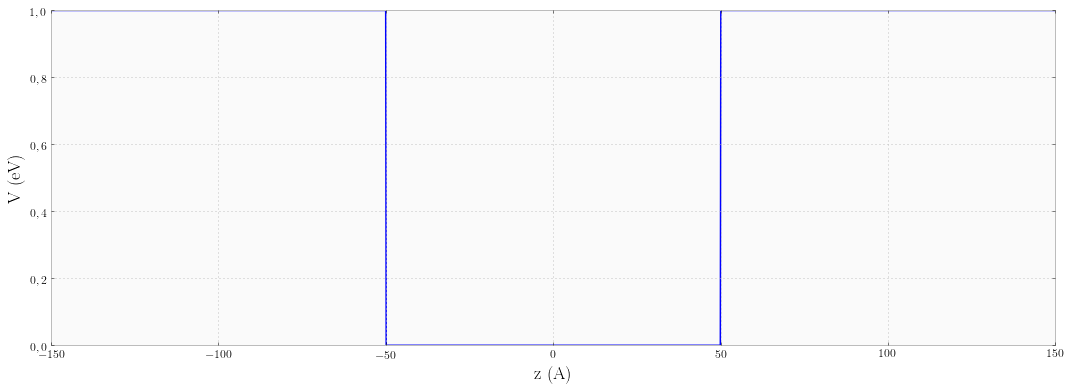

In [13]:
fix, ax = plt.subplots(1,1, figsize=(18,6))
ax.plot(poco_100.z_ang, poco_100.v_ev)
ax.set_xlabel(r'z (A)')
ax.set_ylabel(r'V (eV)')
plt.show()

## Autovalores e autovetores

In [14]:
poco_100.evolucao_imaginaria(precision=1e-4)

In [1]:
import pandas as pd
df = pd.read_csv('saidas/absorption.csv')

In [8]:
energy = df.energy.values
d1i = df.d1i.values
d1r = df.d1r.values
d2i = df.d2i.values
d2r = df.d2r.values

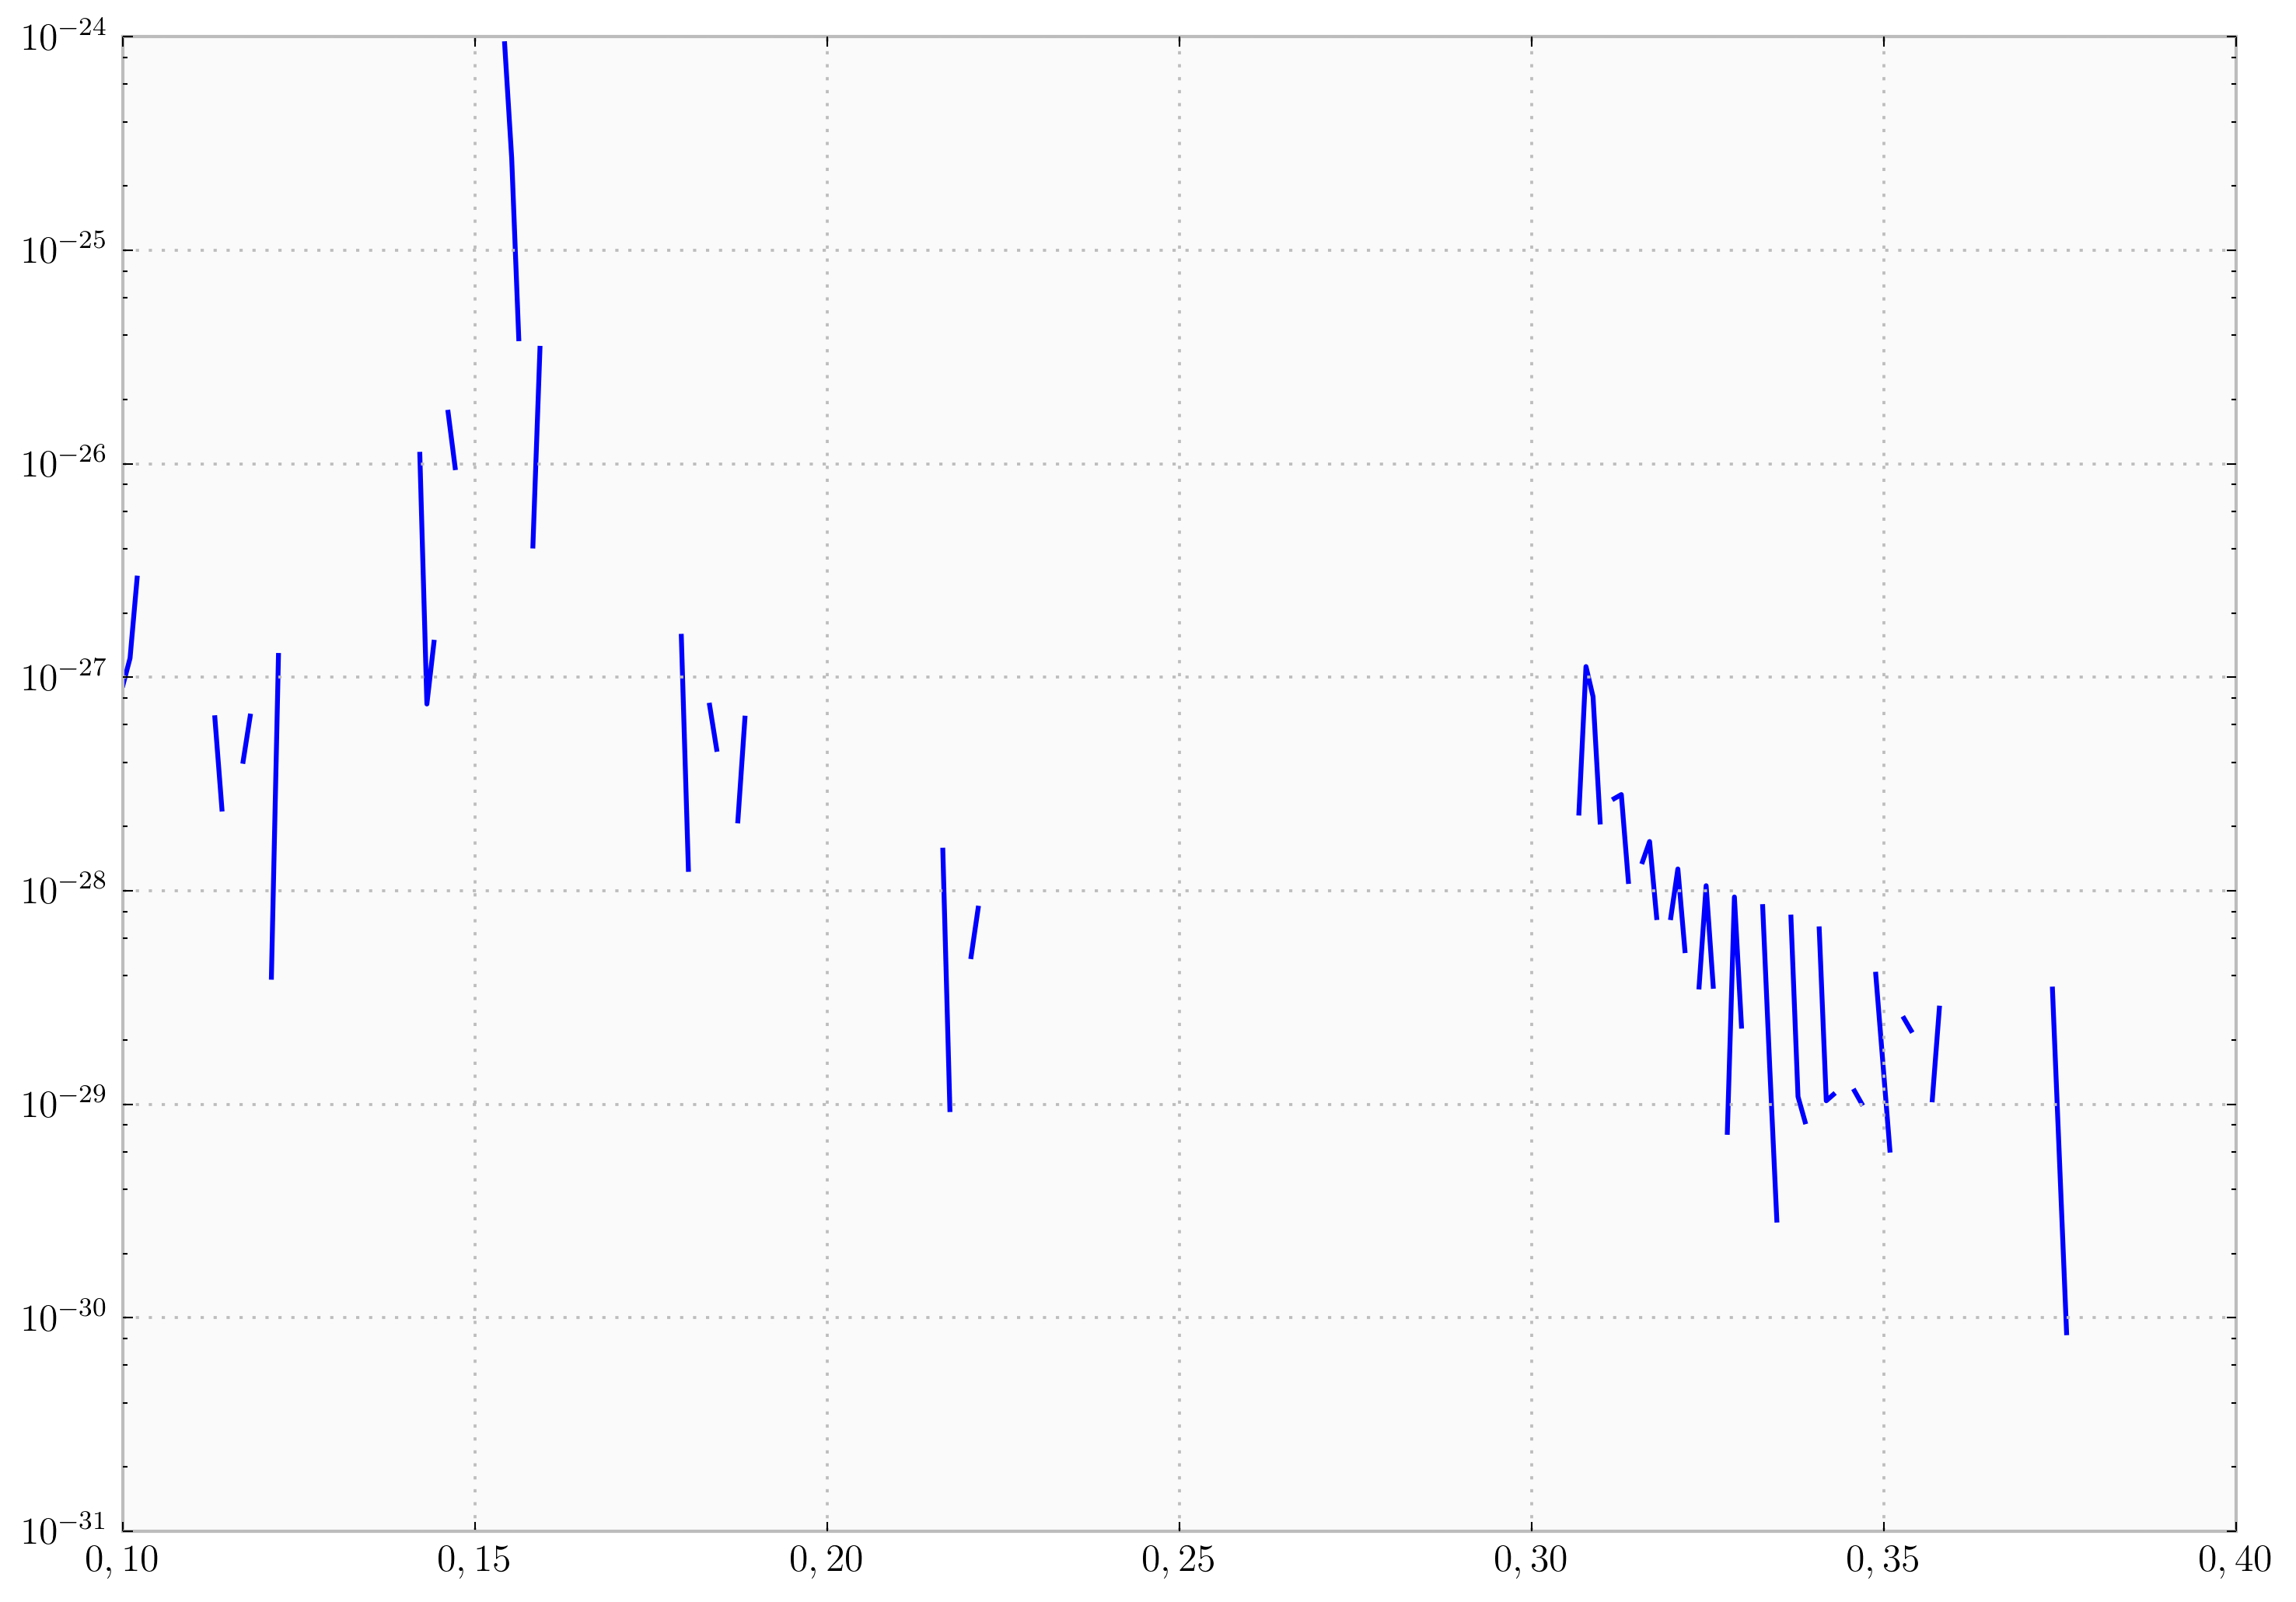

In [9]:
plt.semilogy(energy, d1i)
plt.show()

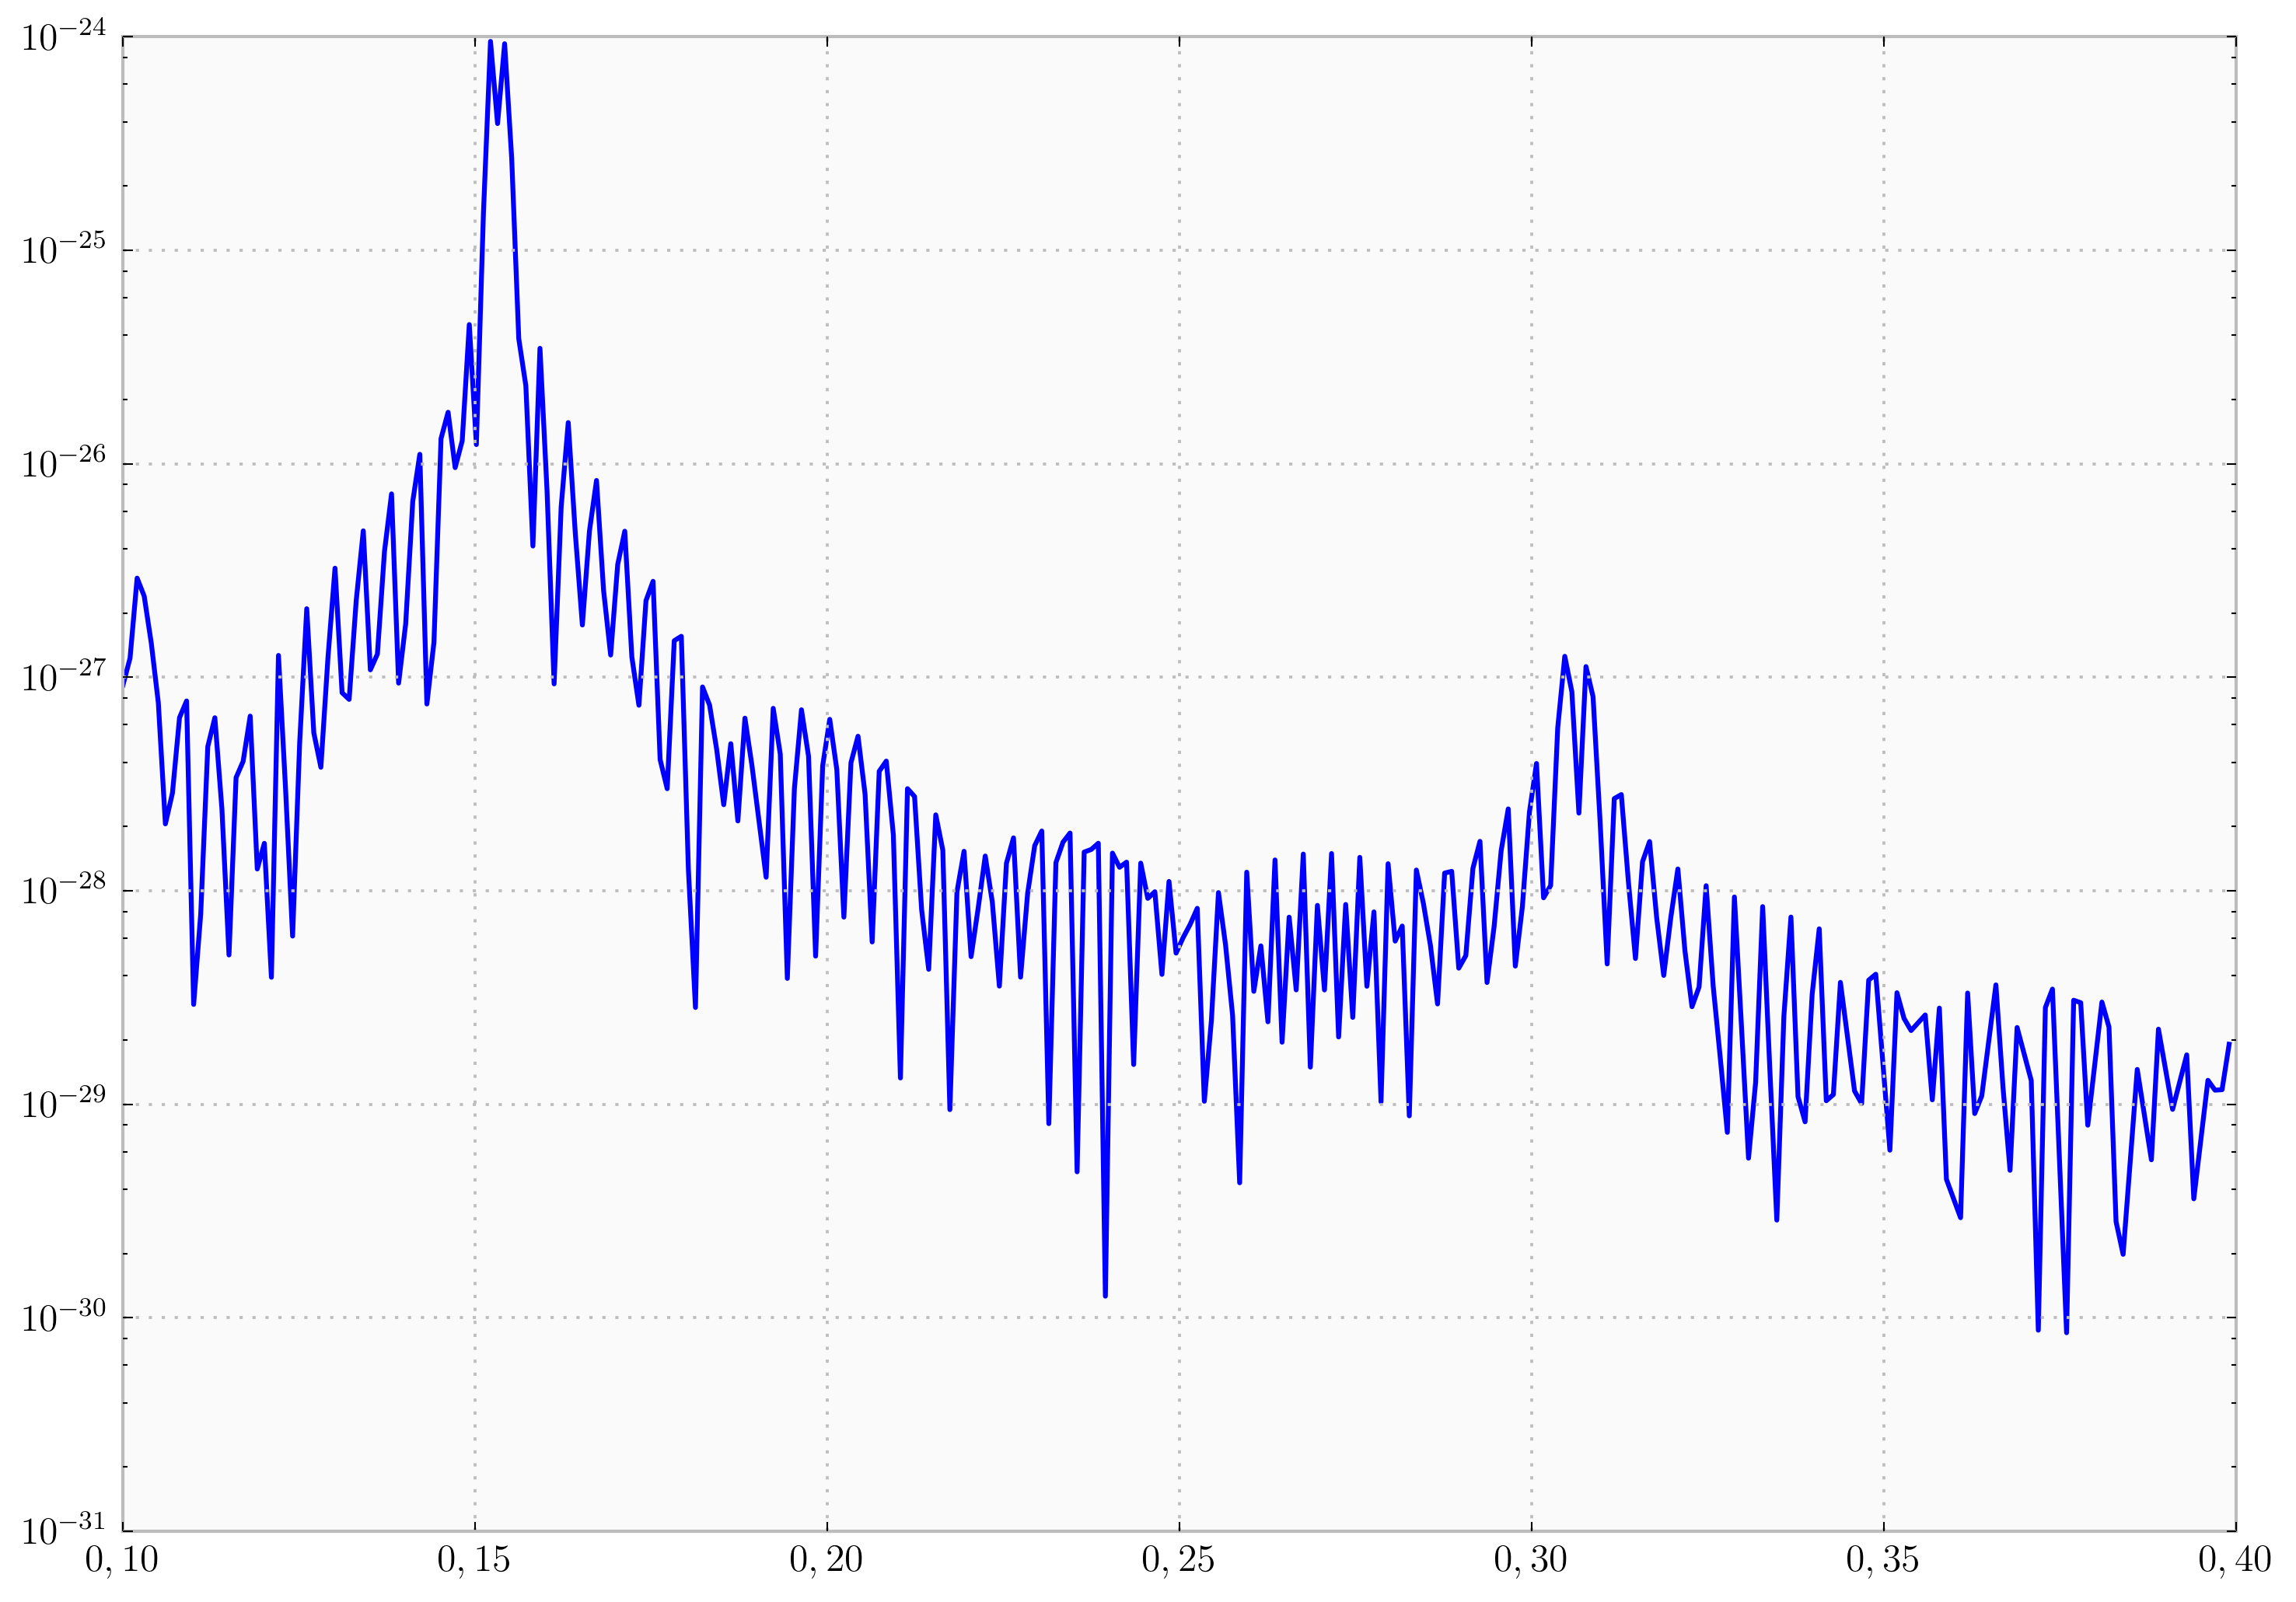

In [10]:
plt.semilogy(energy, np.abs(d1i))
plt.show()

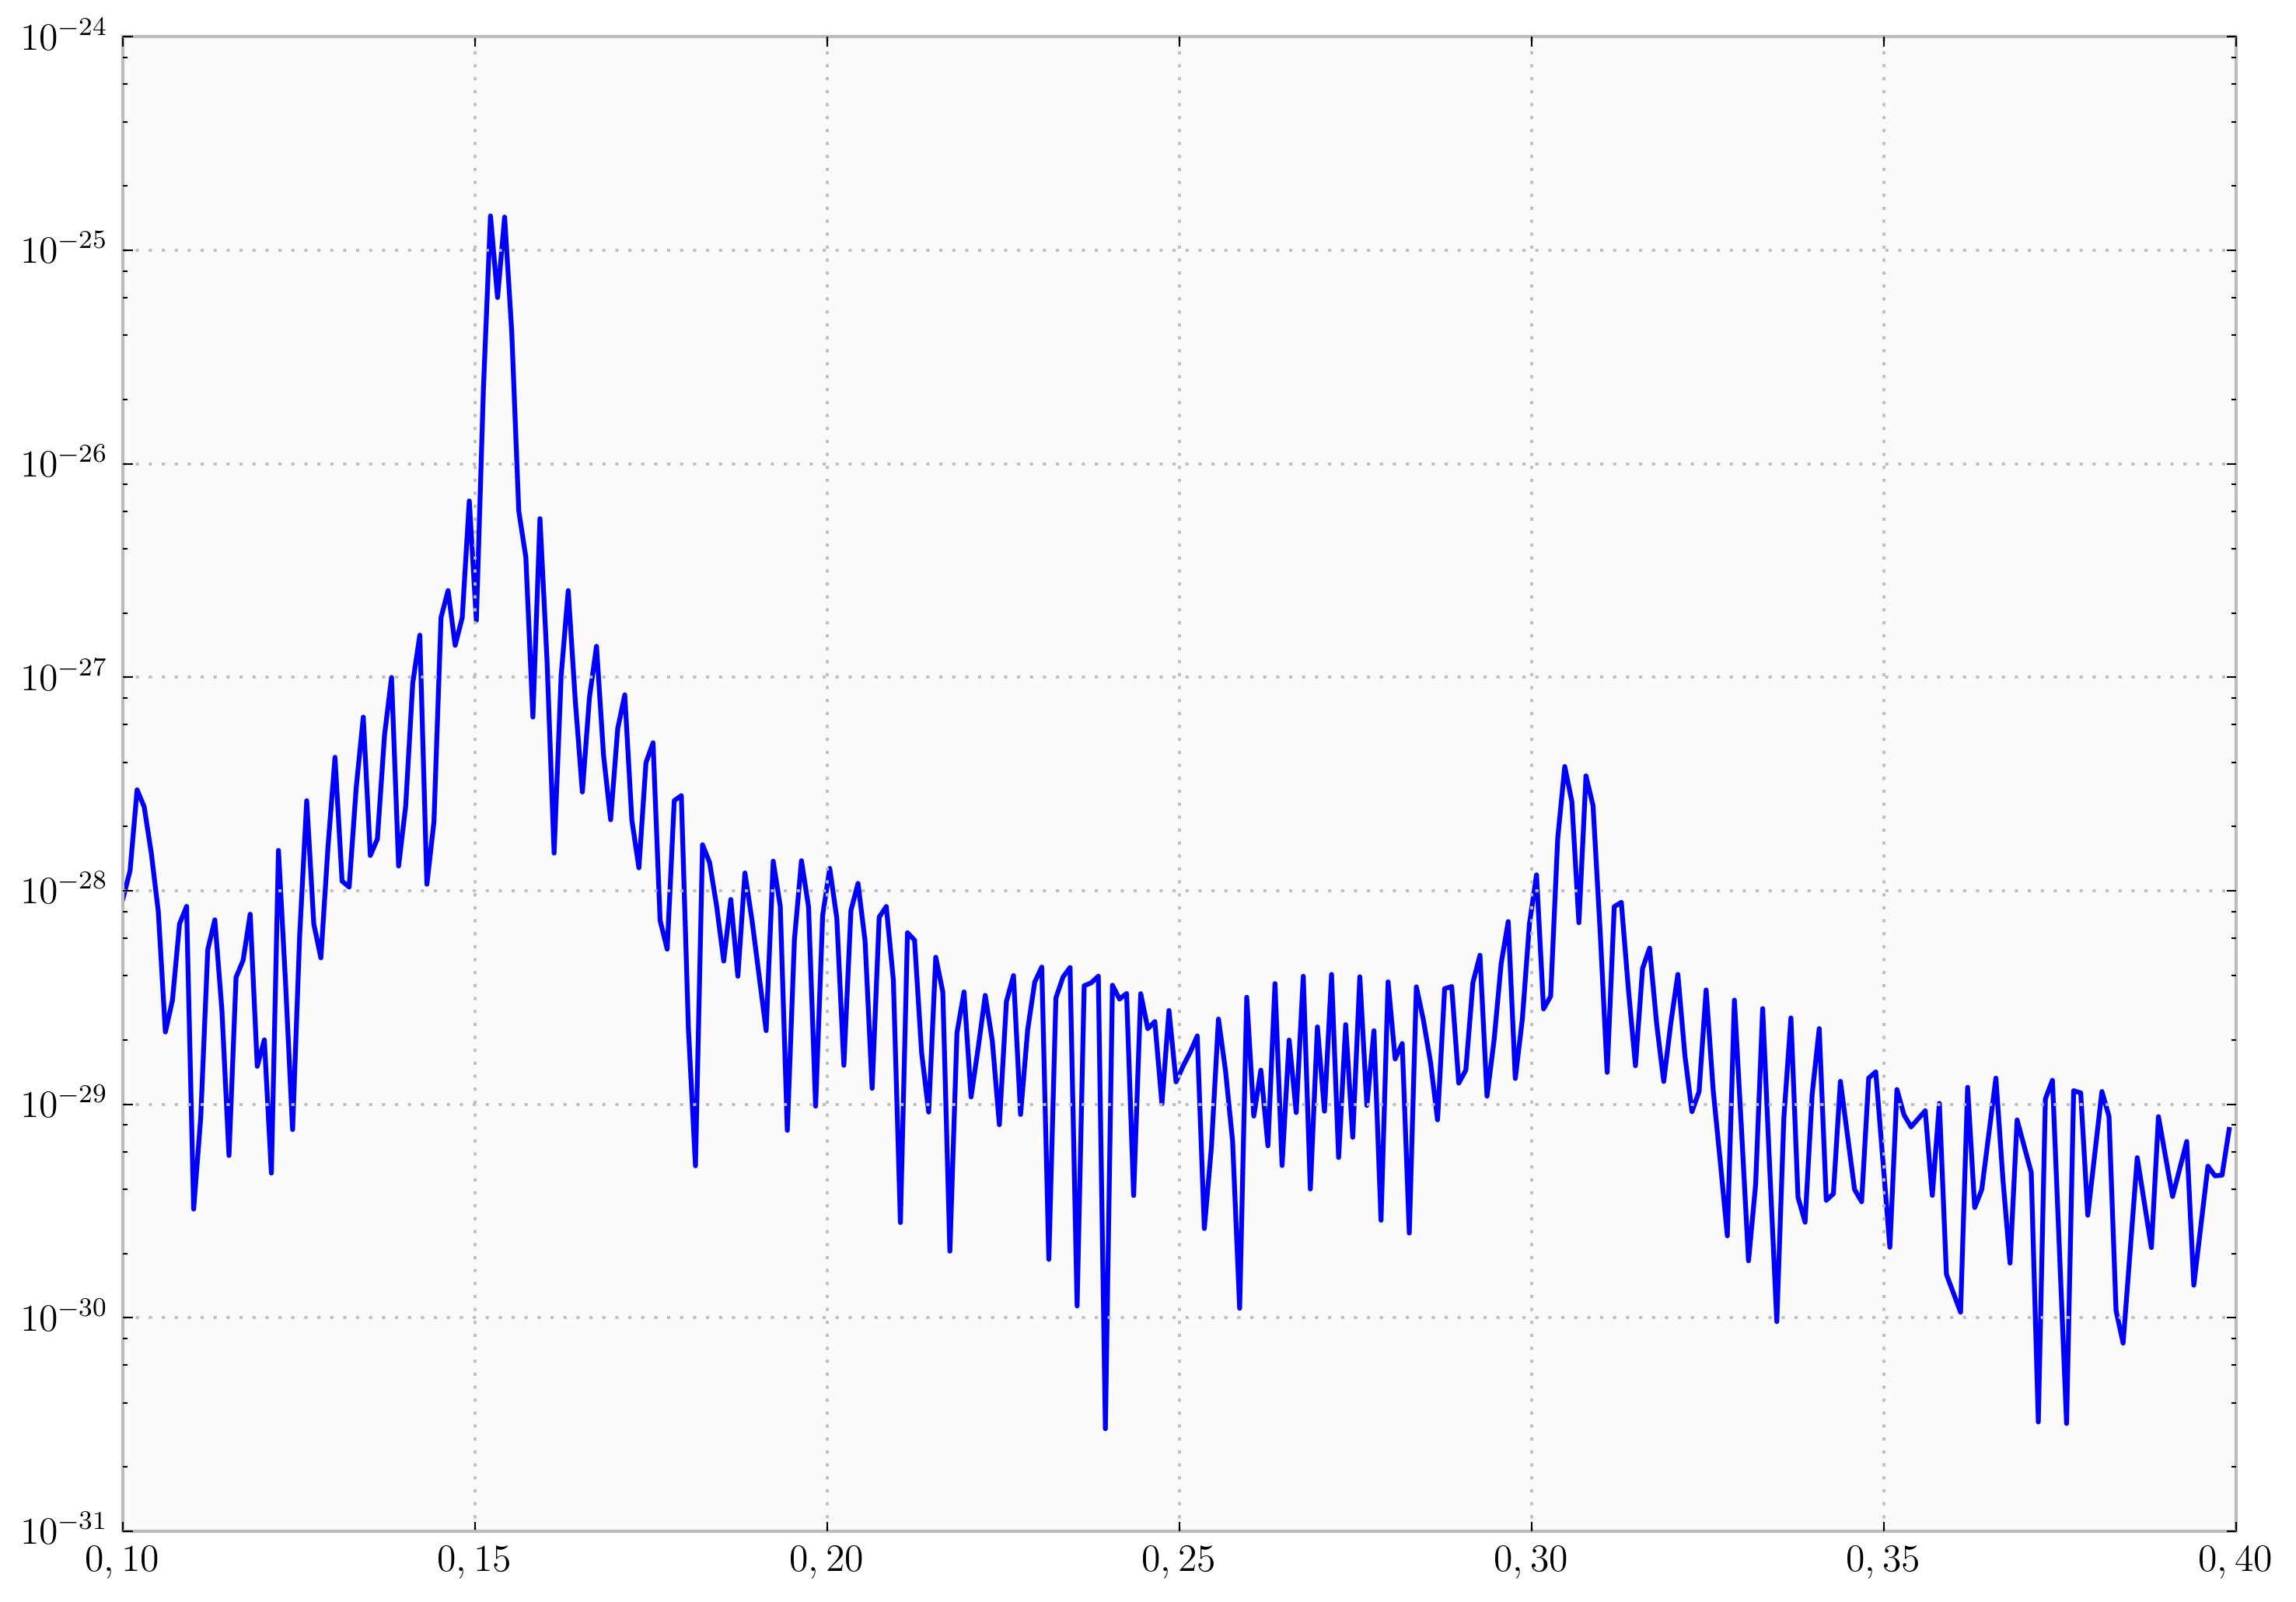

In [11]:
plt.semilogy(energy, energy*np.abs(d1i))
plt.show()

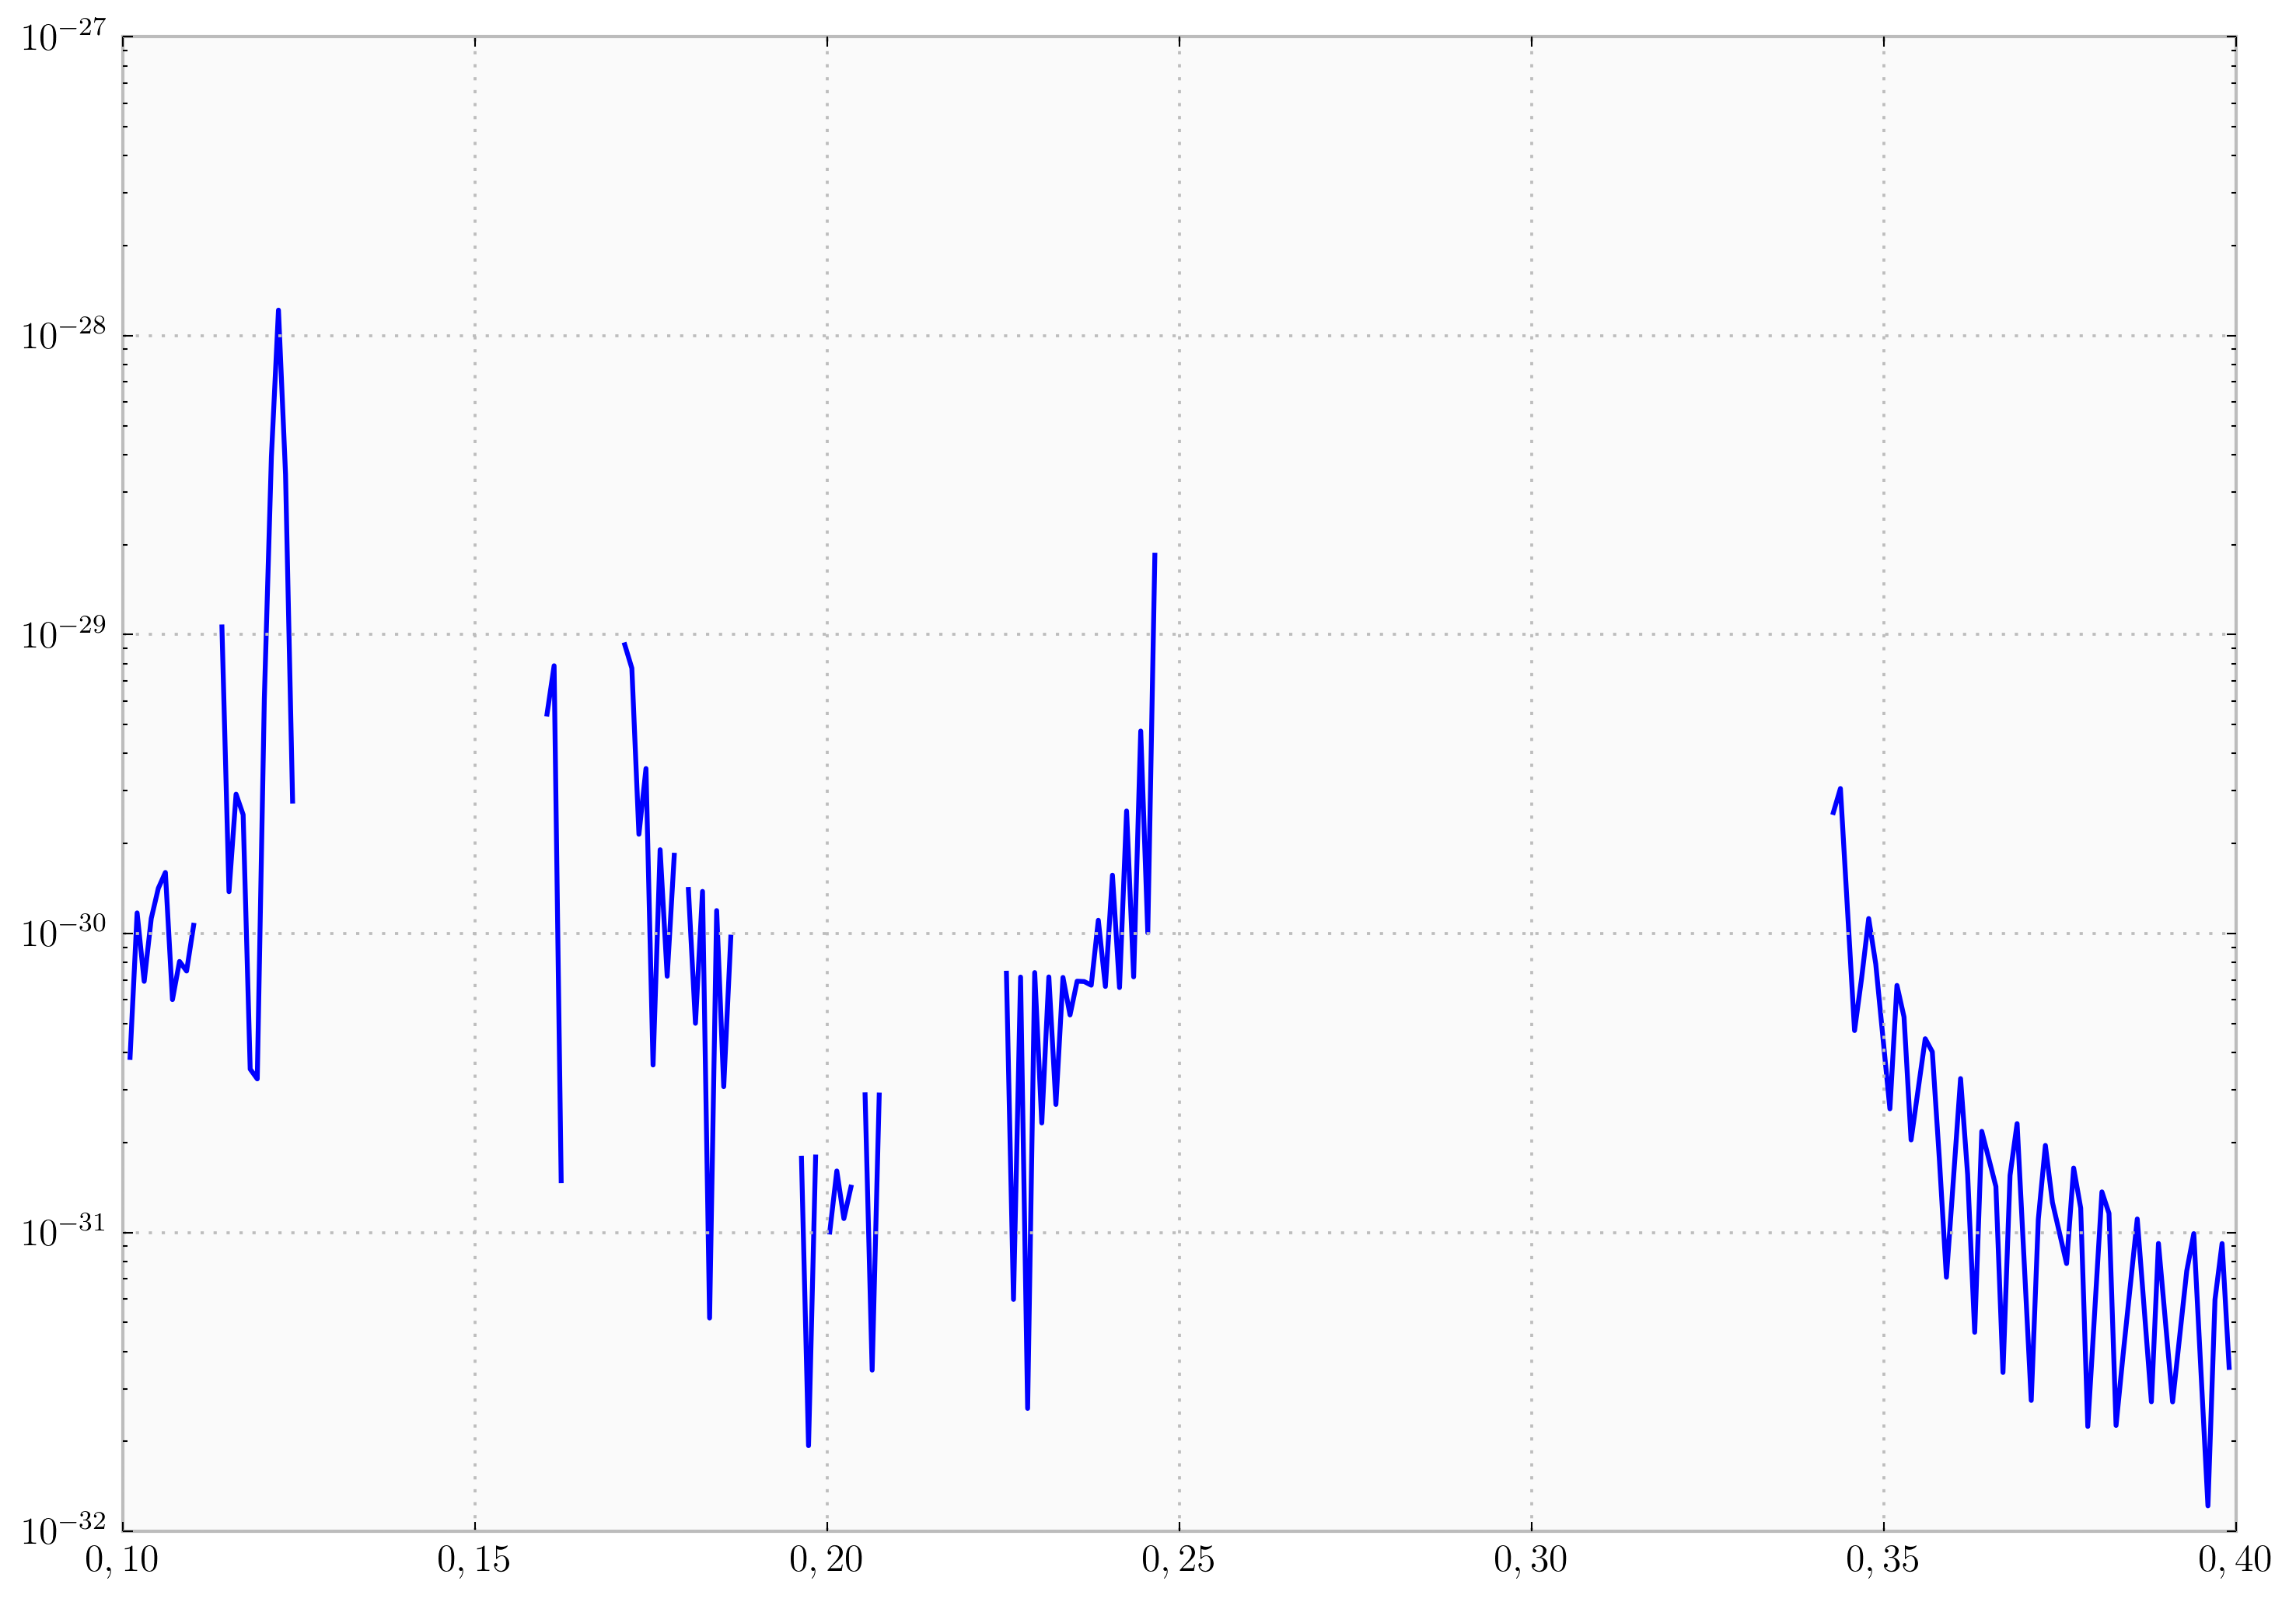

In [12]:
plt.semilogy(energy, d2i)
plt.show()

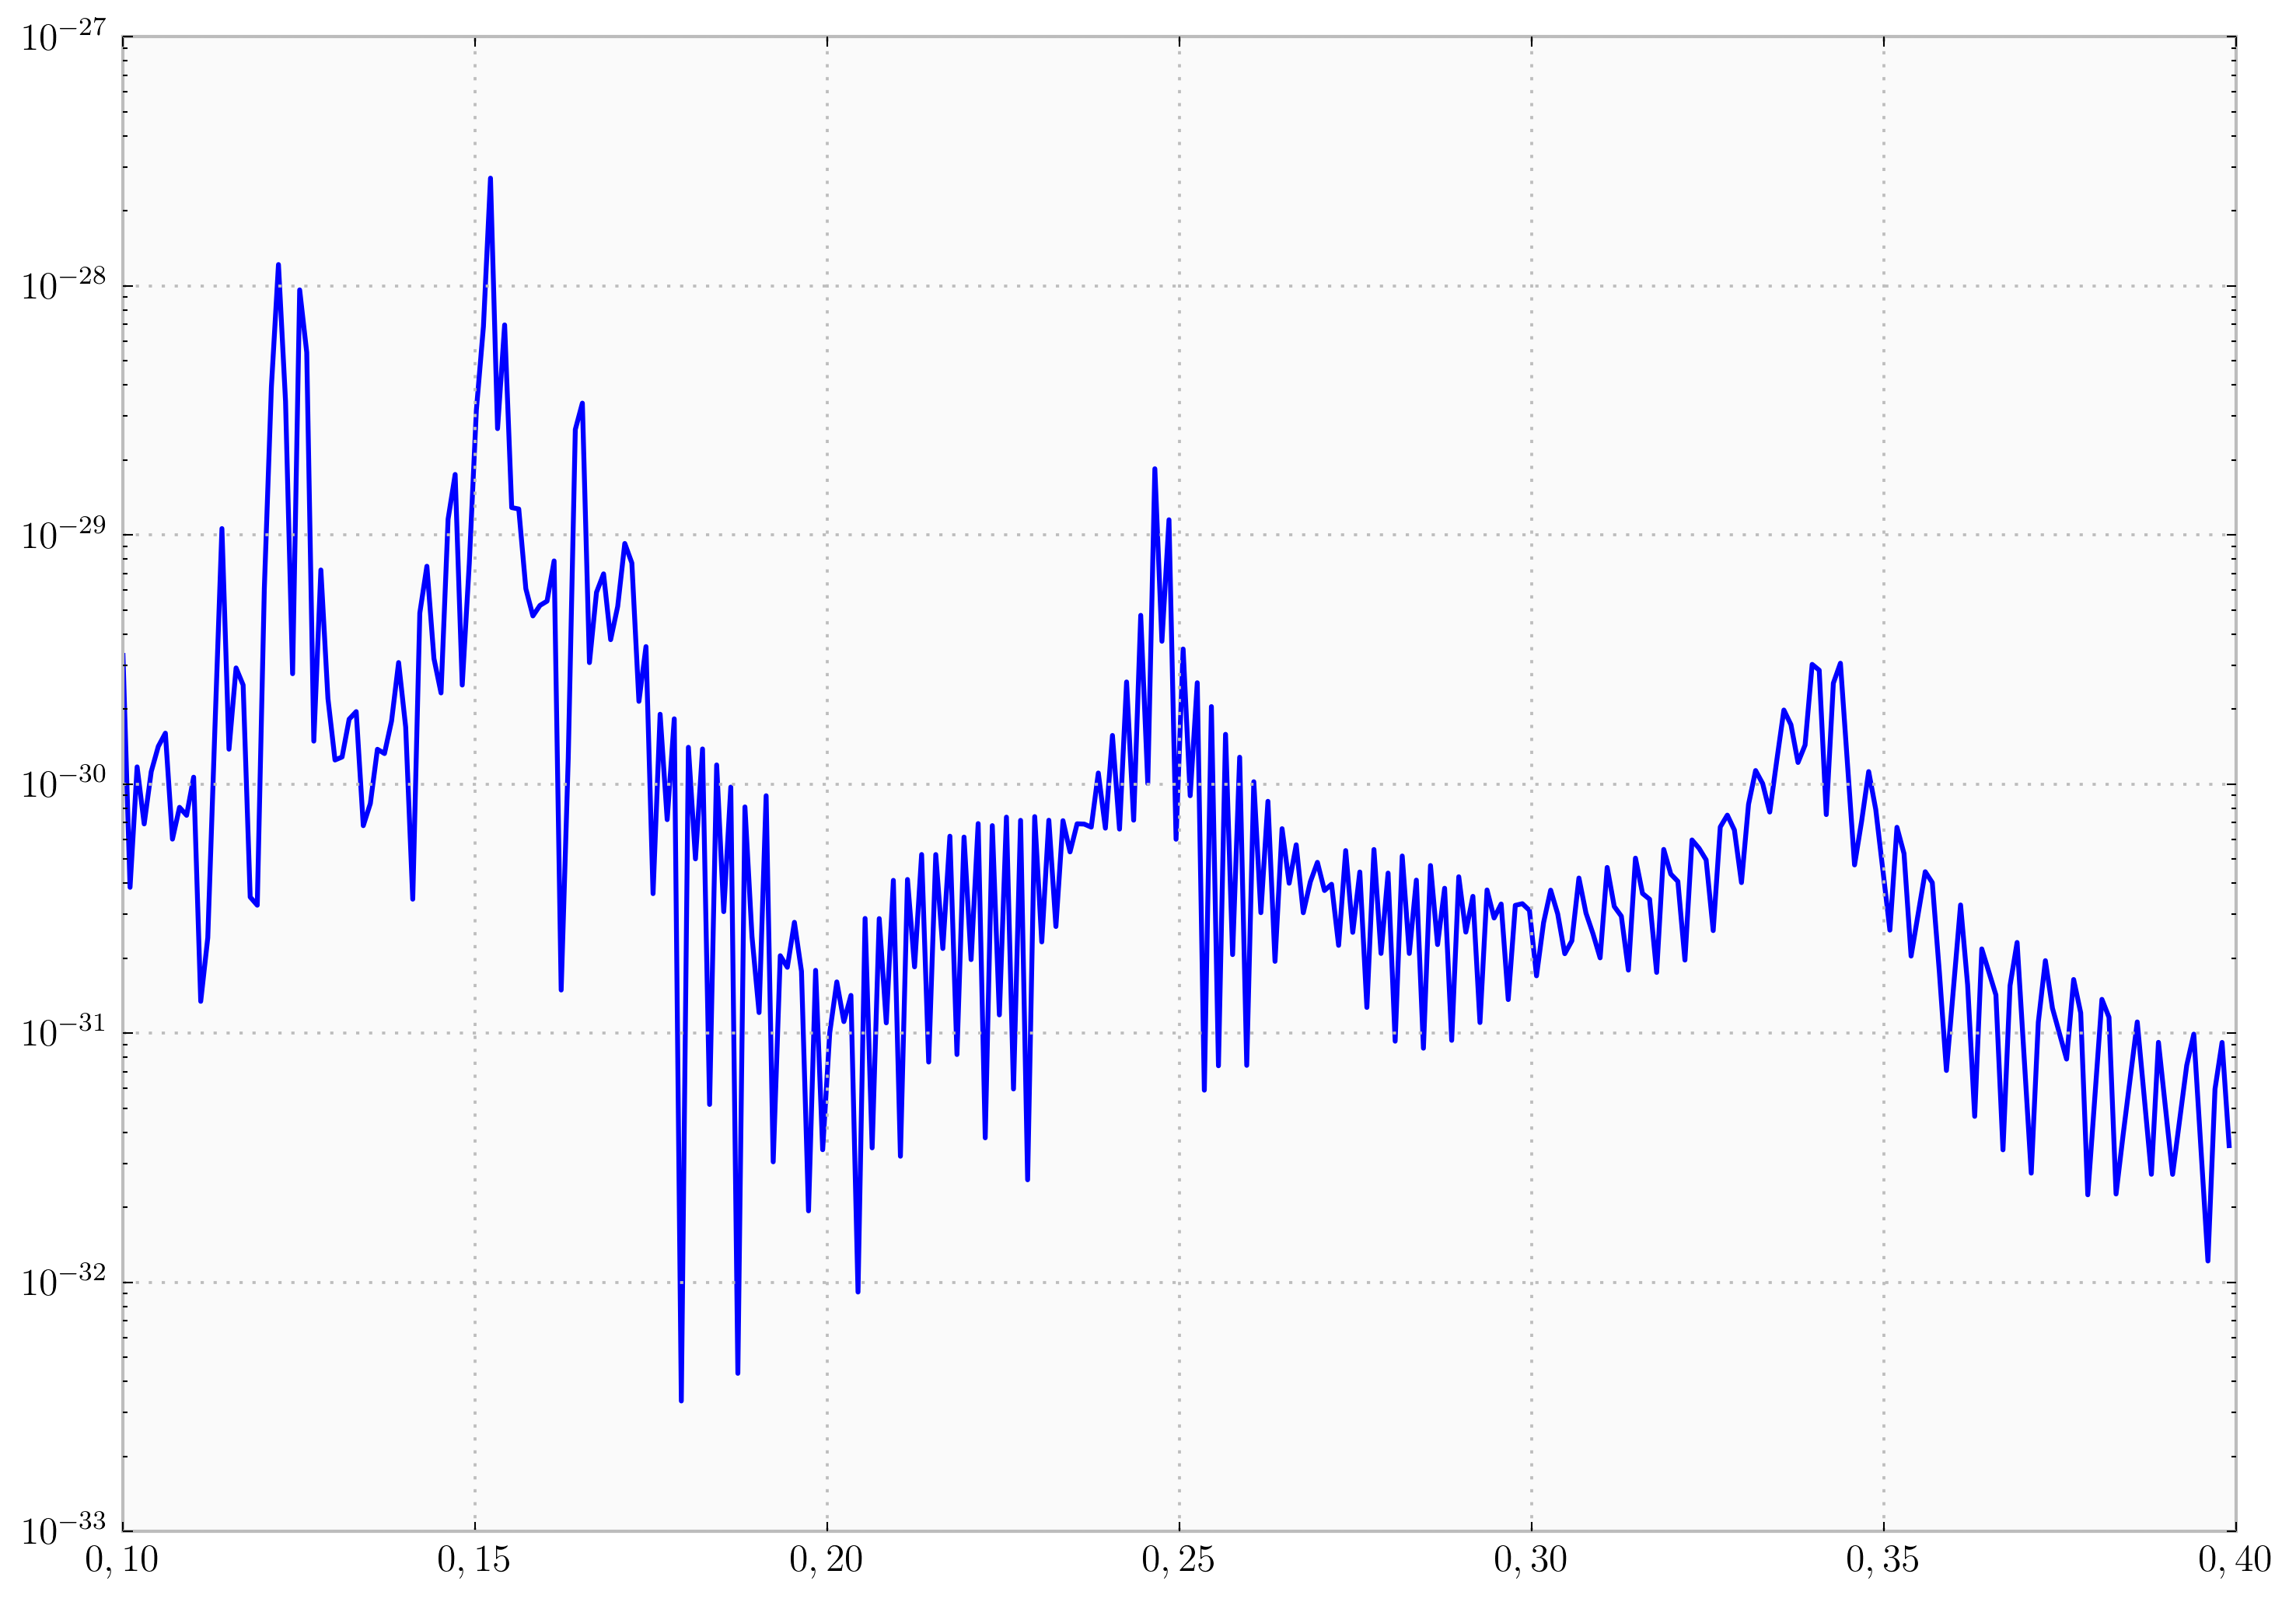

In [13]:
plt.semilogy(energy, np.abs(d2i))
plt.show()

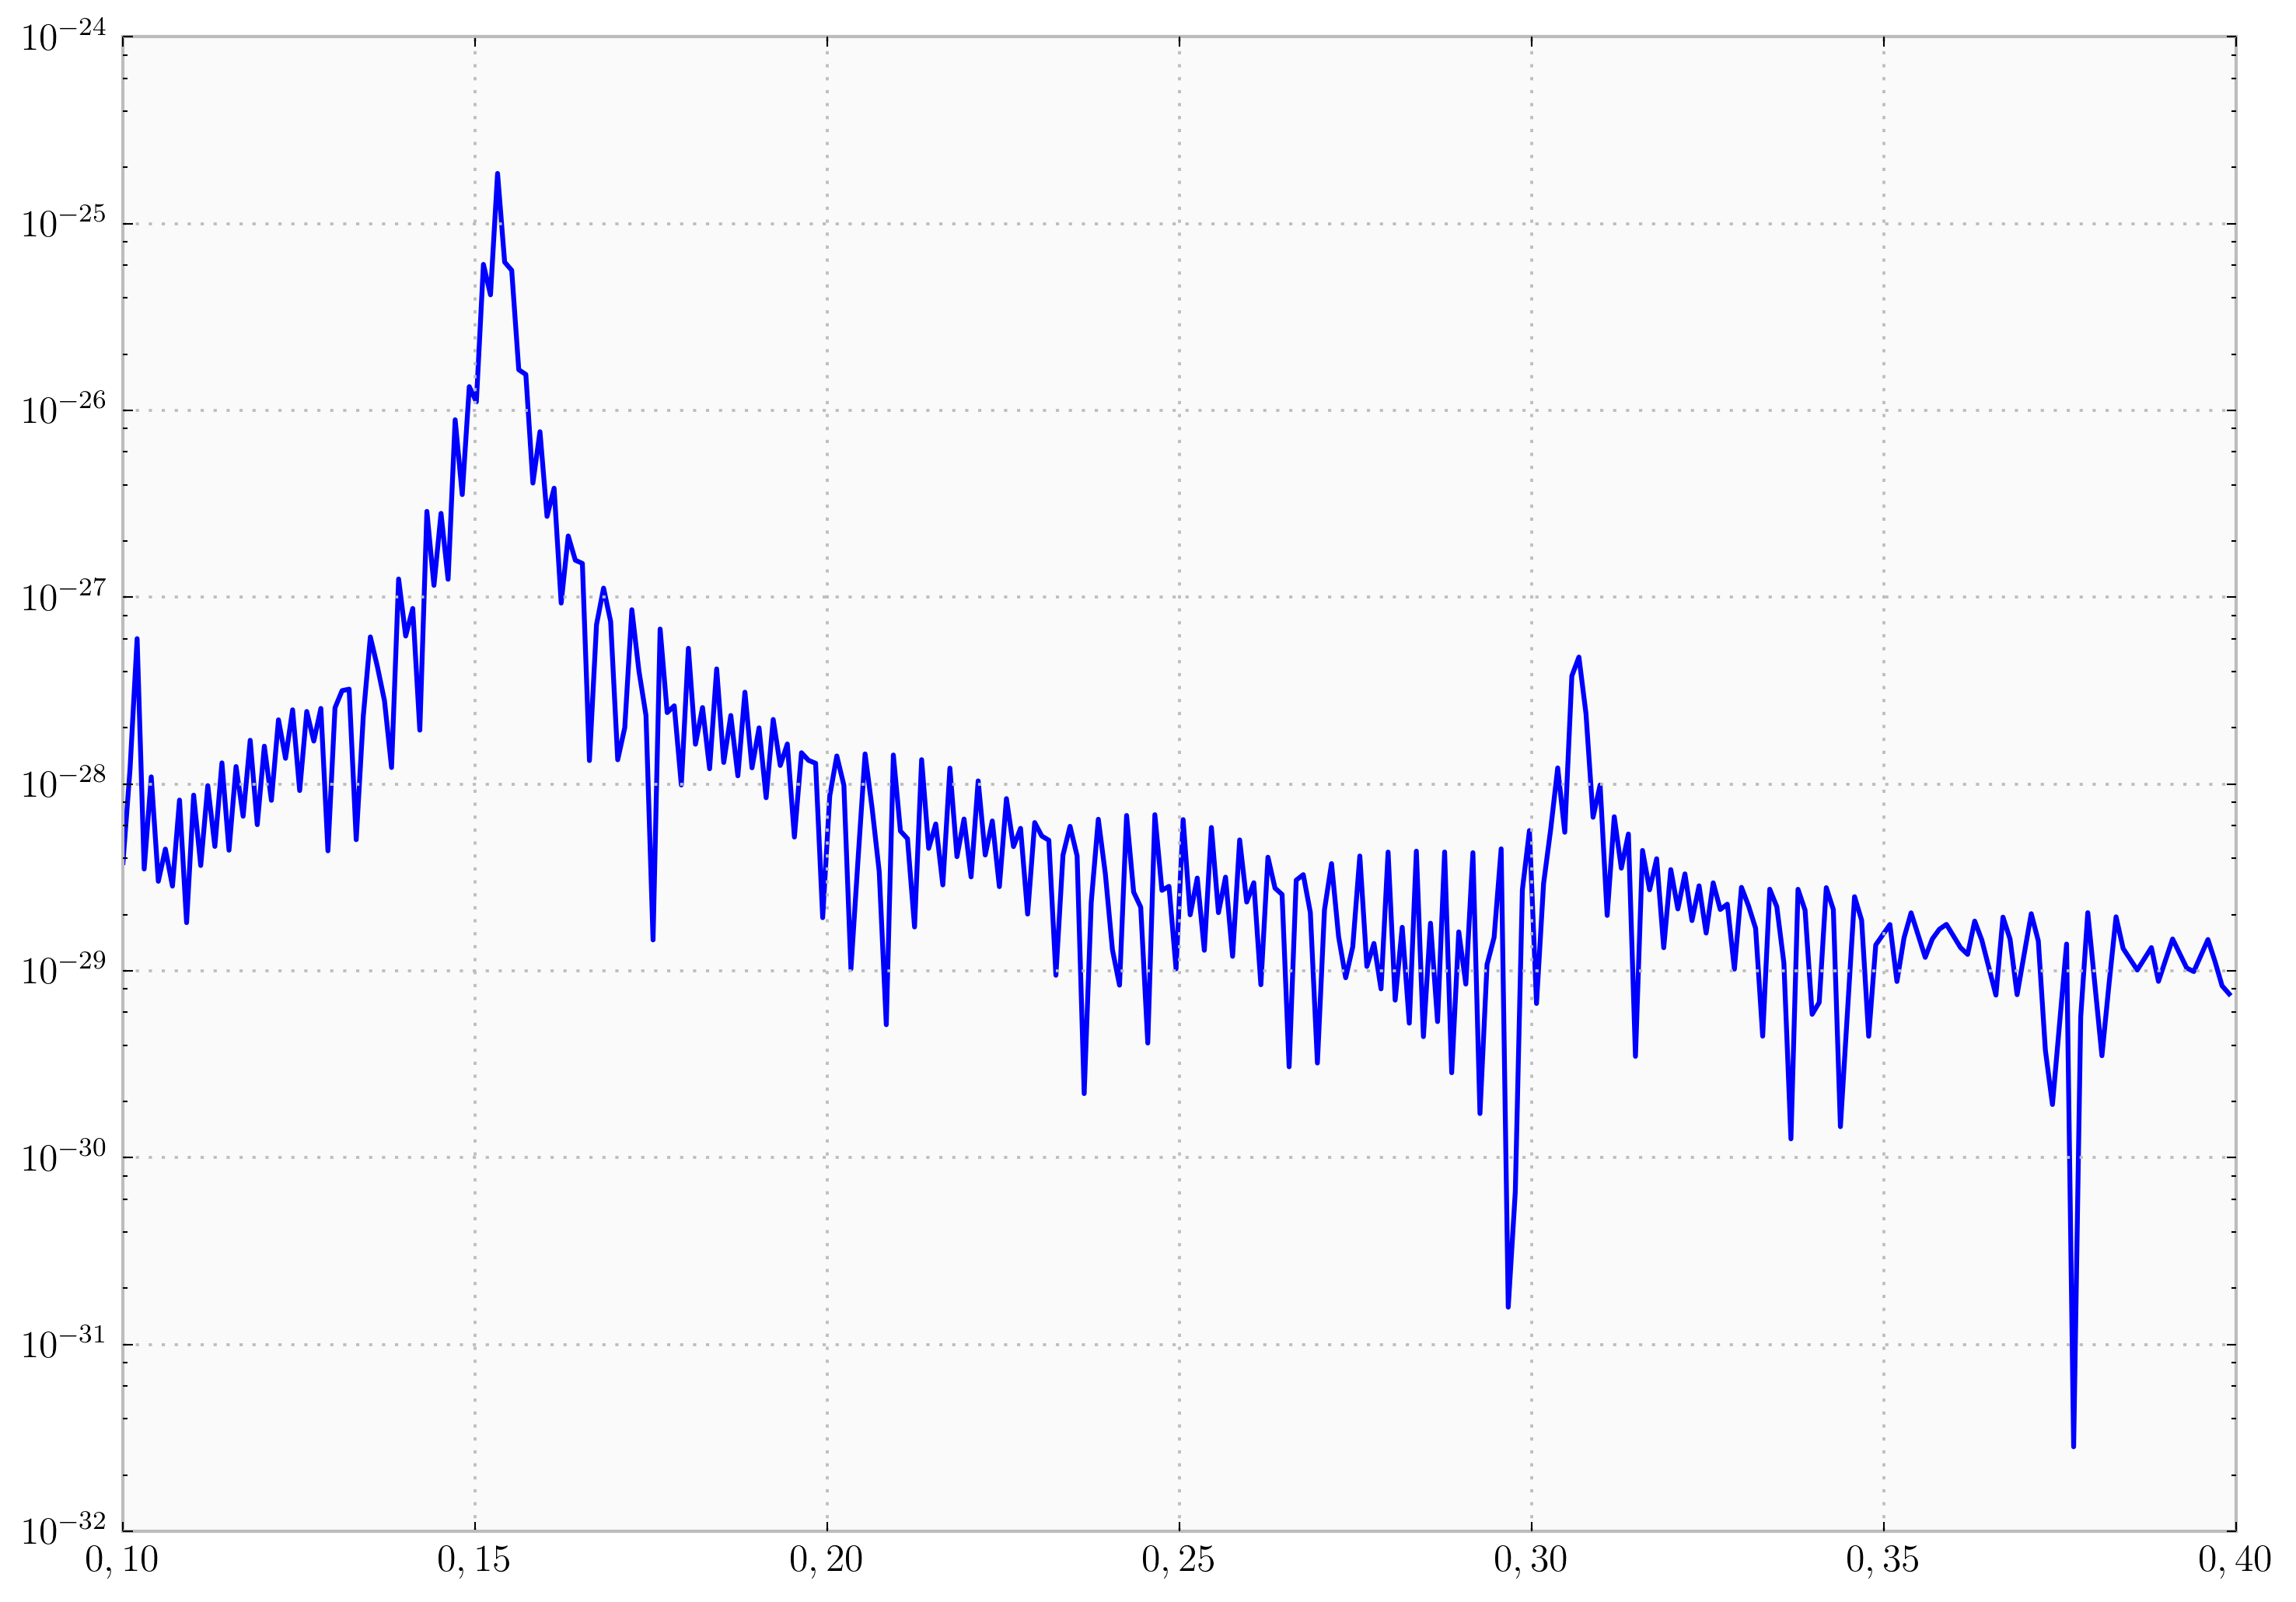

In [25]:
plt.semilogy(energy, energy*(np.abs(d1r)+np.abs(d2r)))
plt.show()

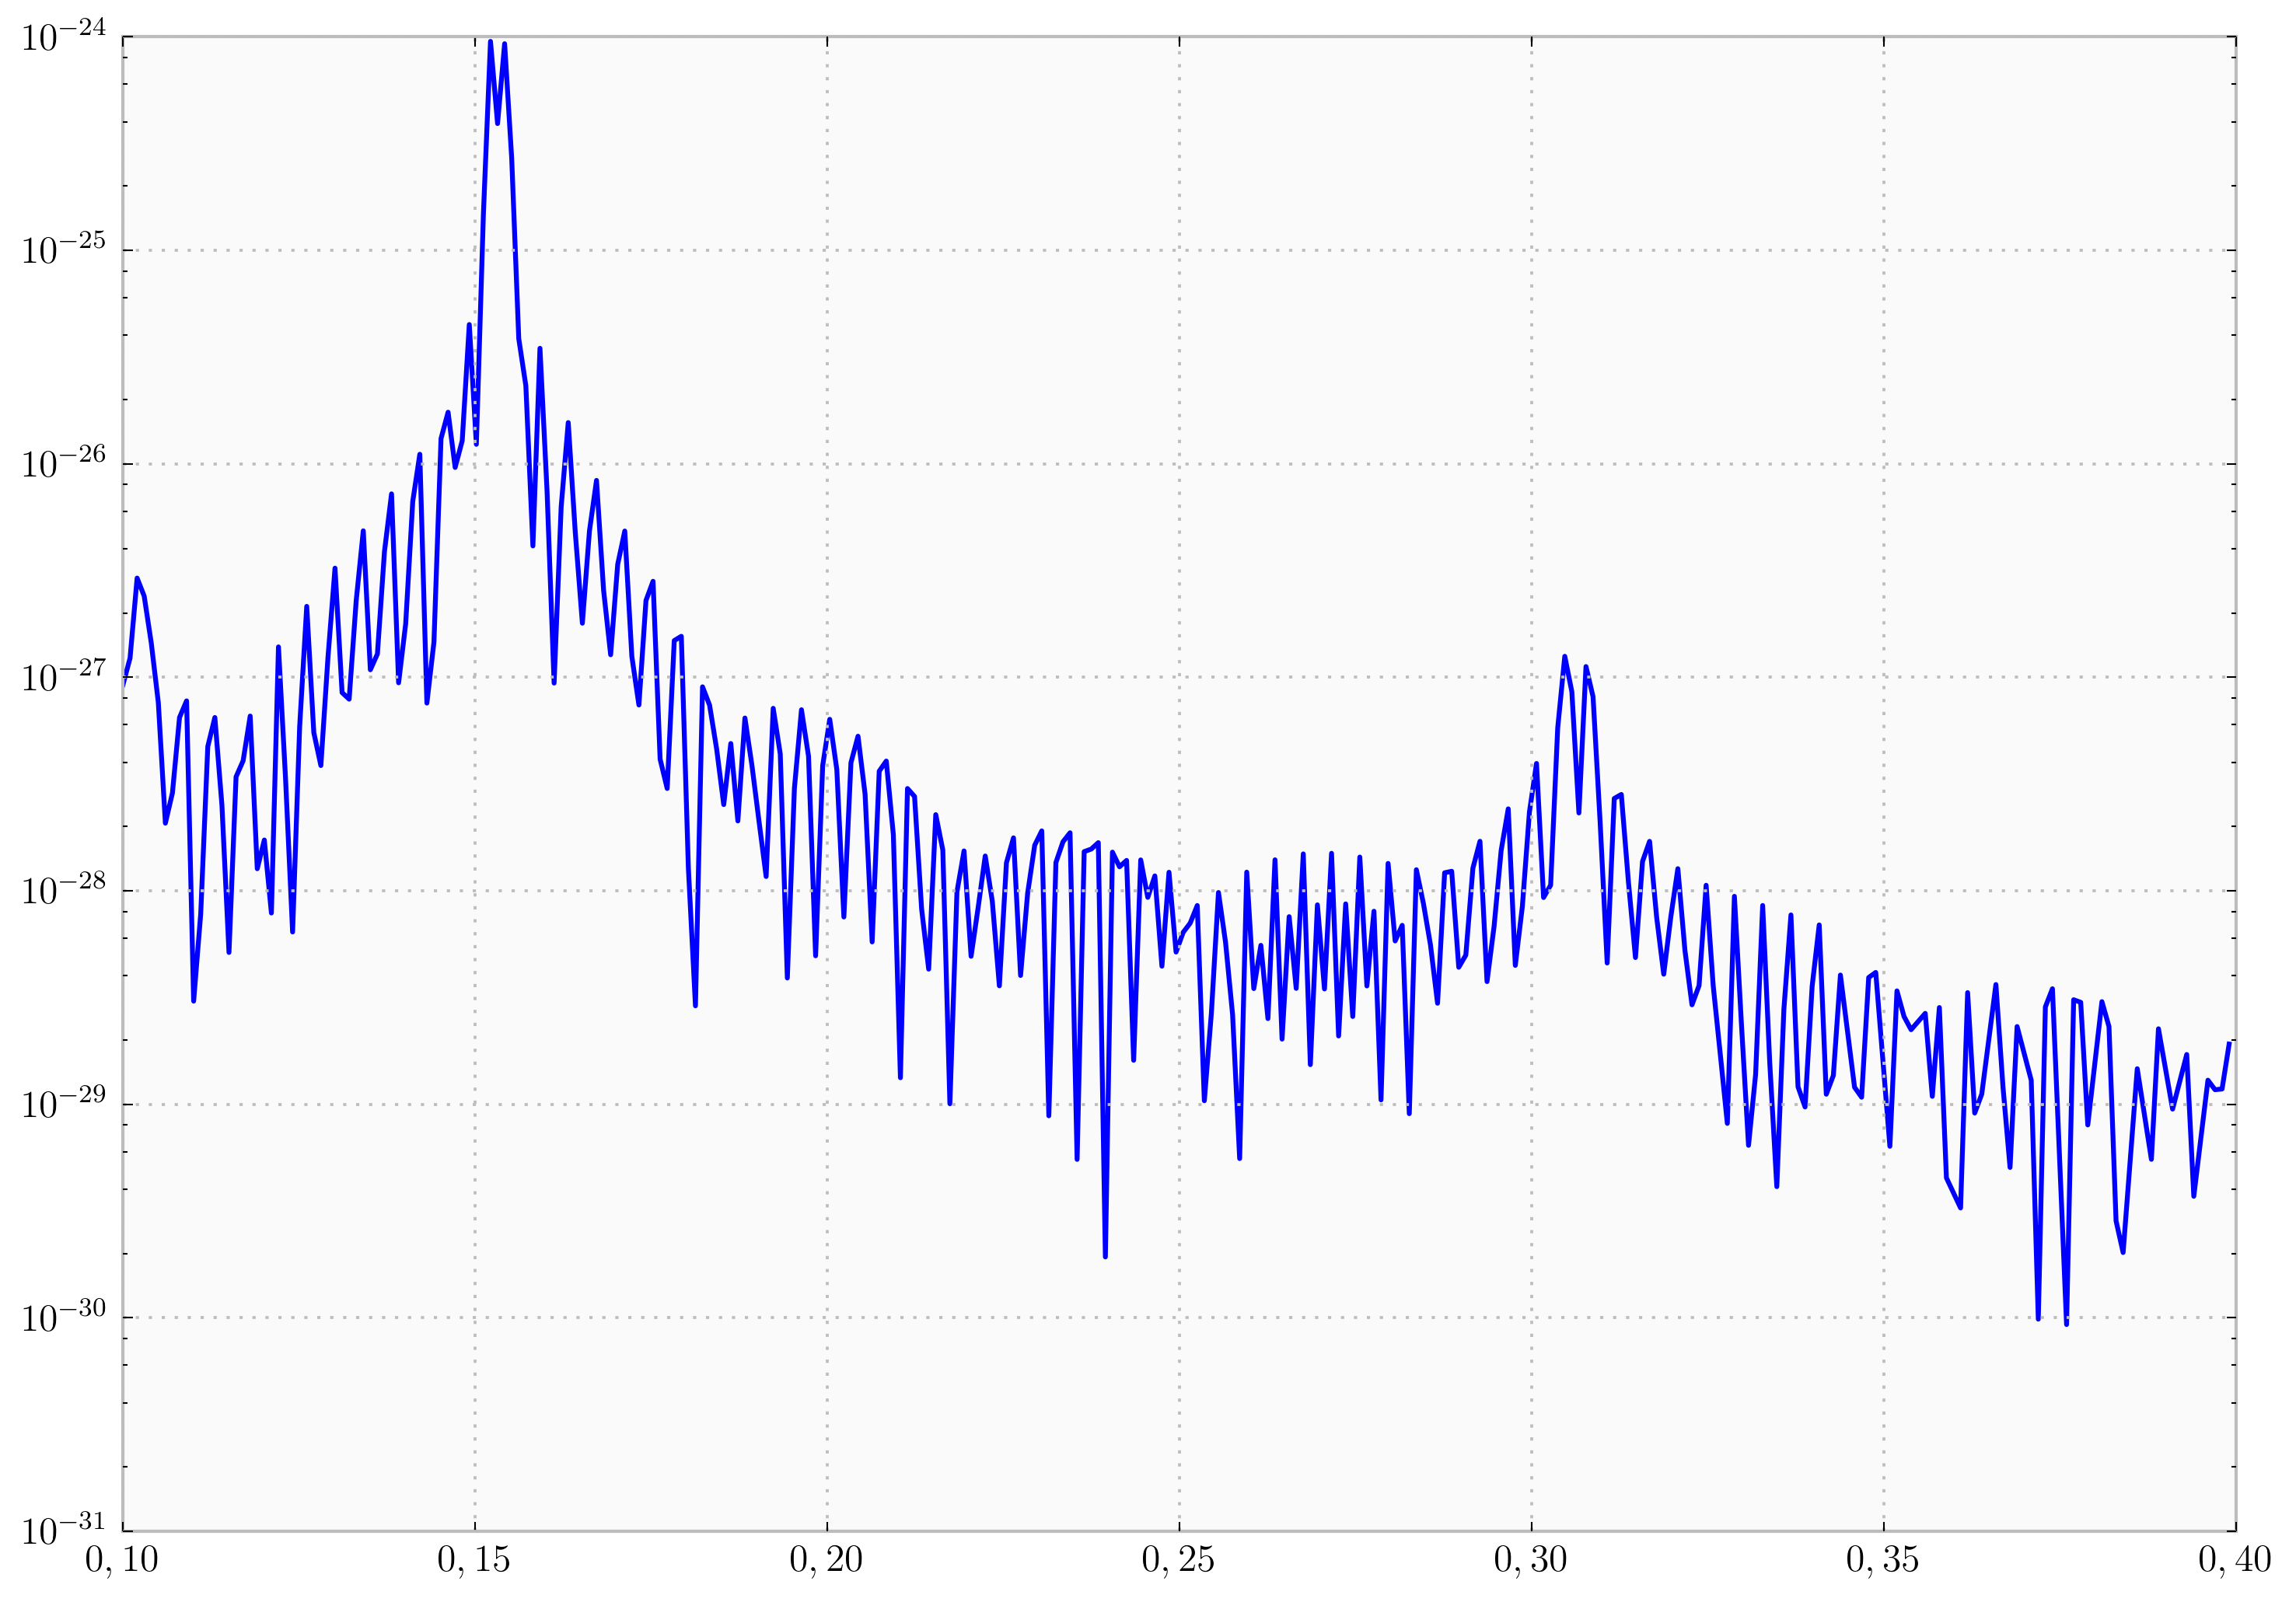

In [22]:
plt.semilogy(energy, (np.abs(d1i)+np.abs(d2i)))
plt.show()

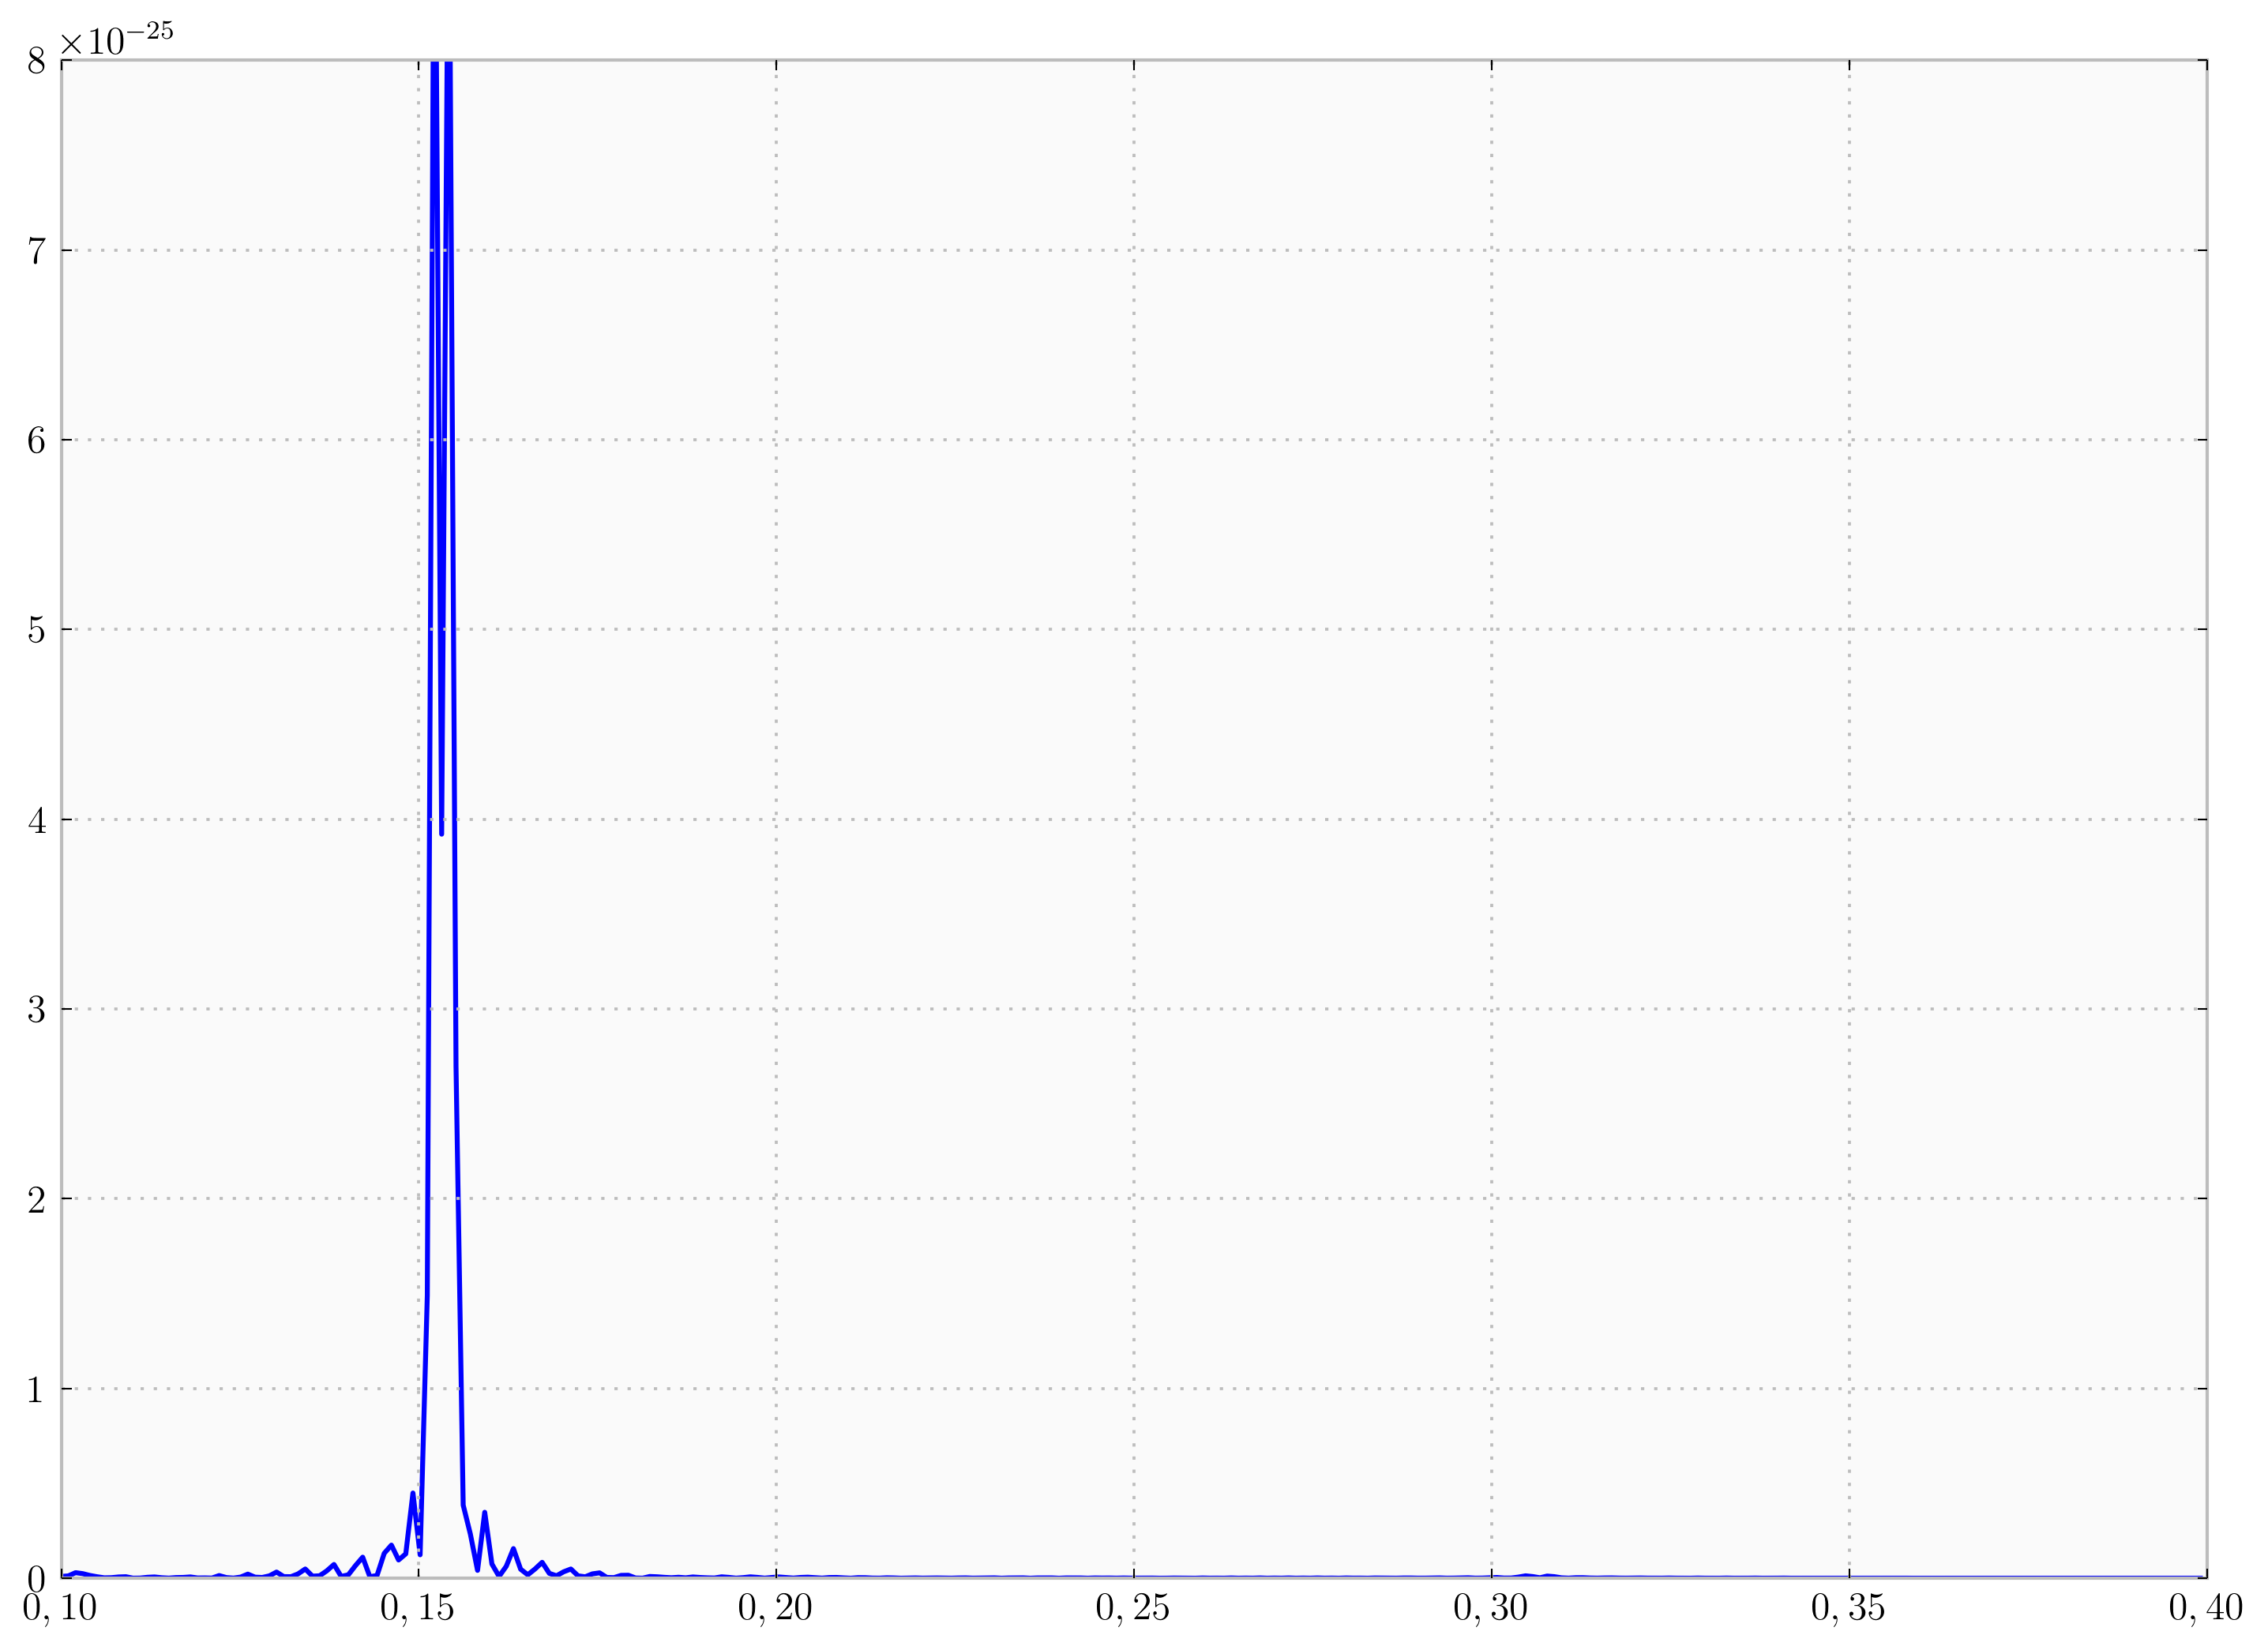

In [23]:
plt.plot(energy, (np.abs(d1i)+np.abs(d2i)))
plt.show()

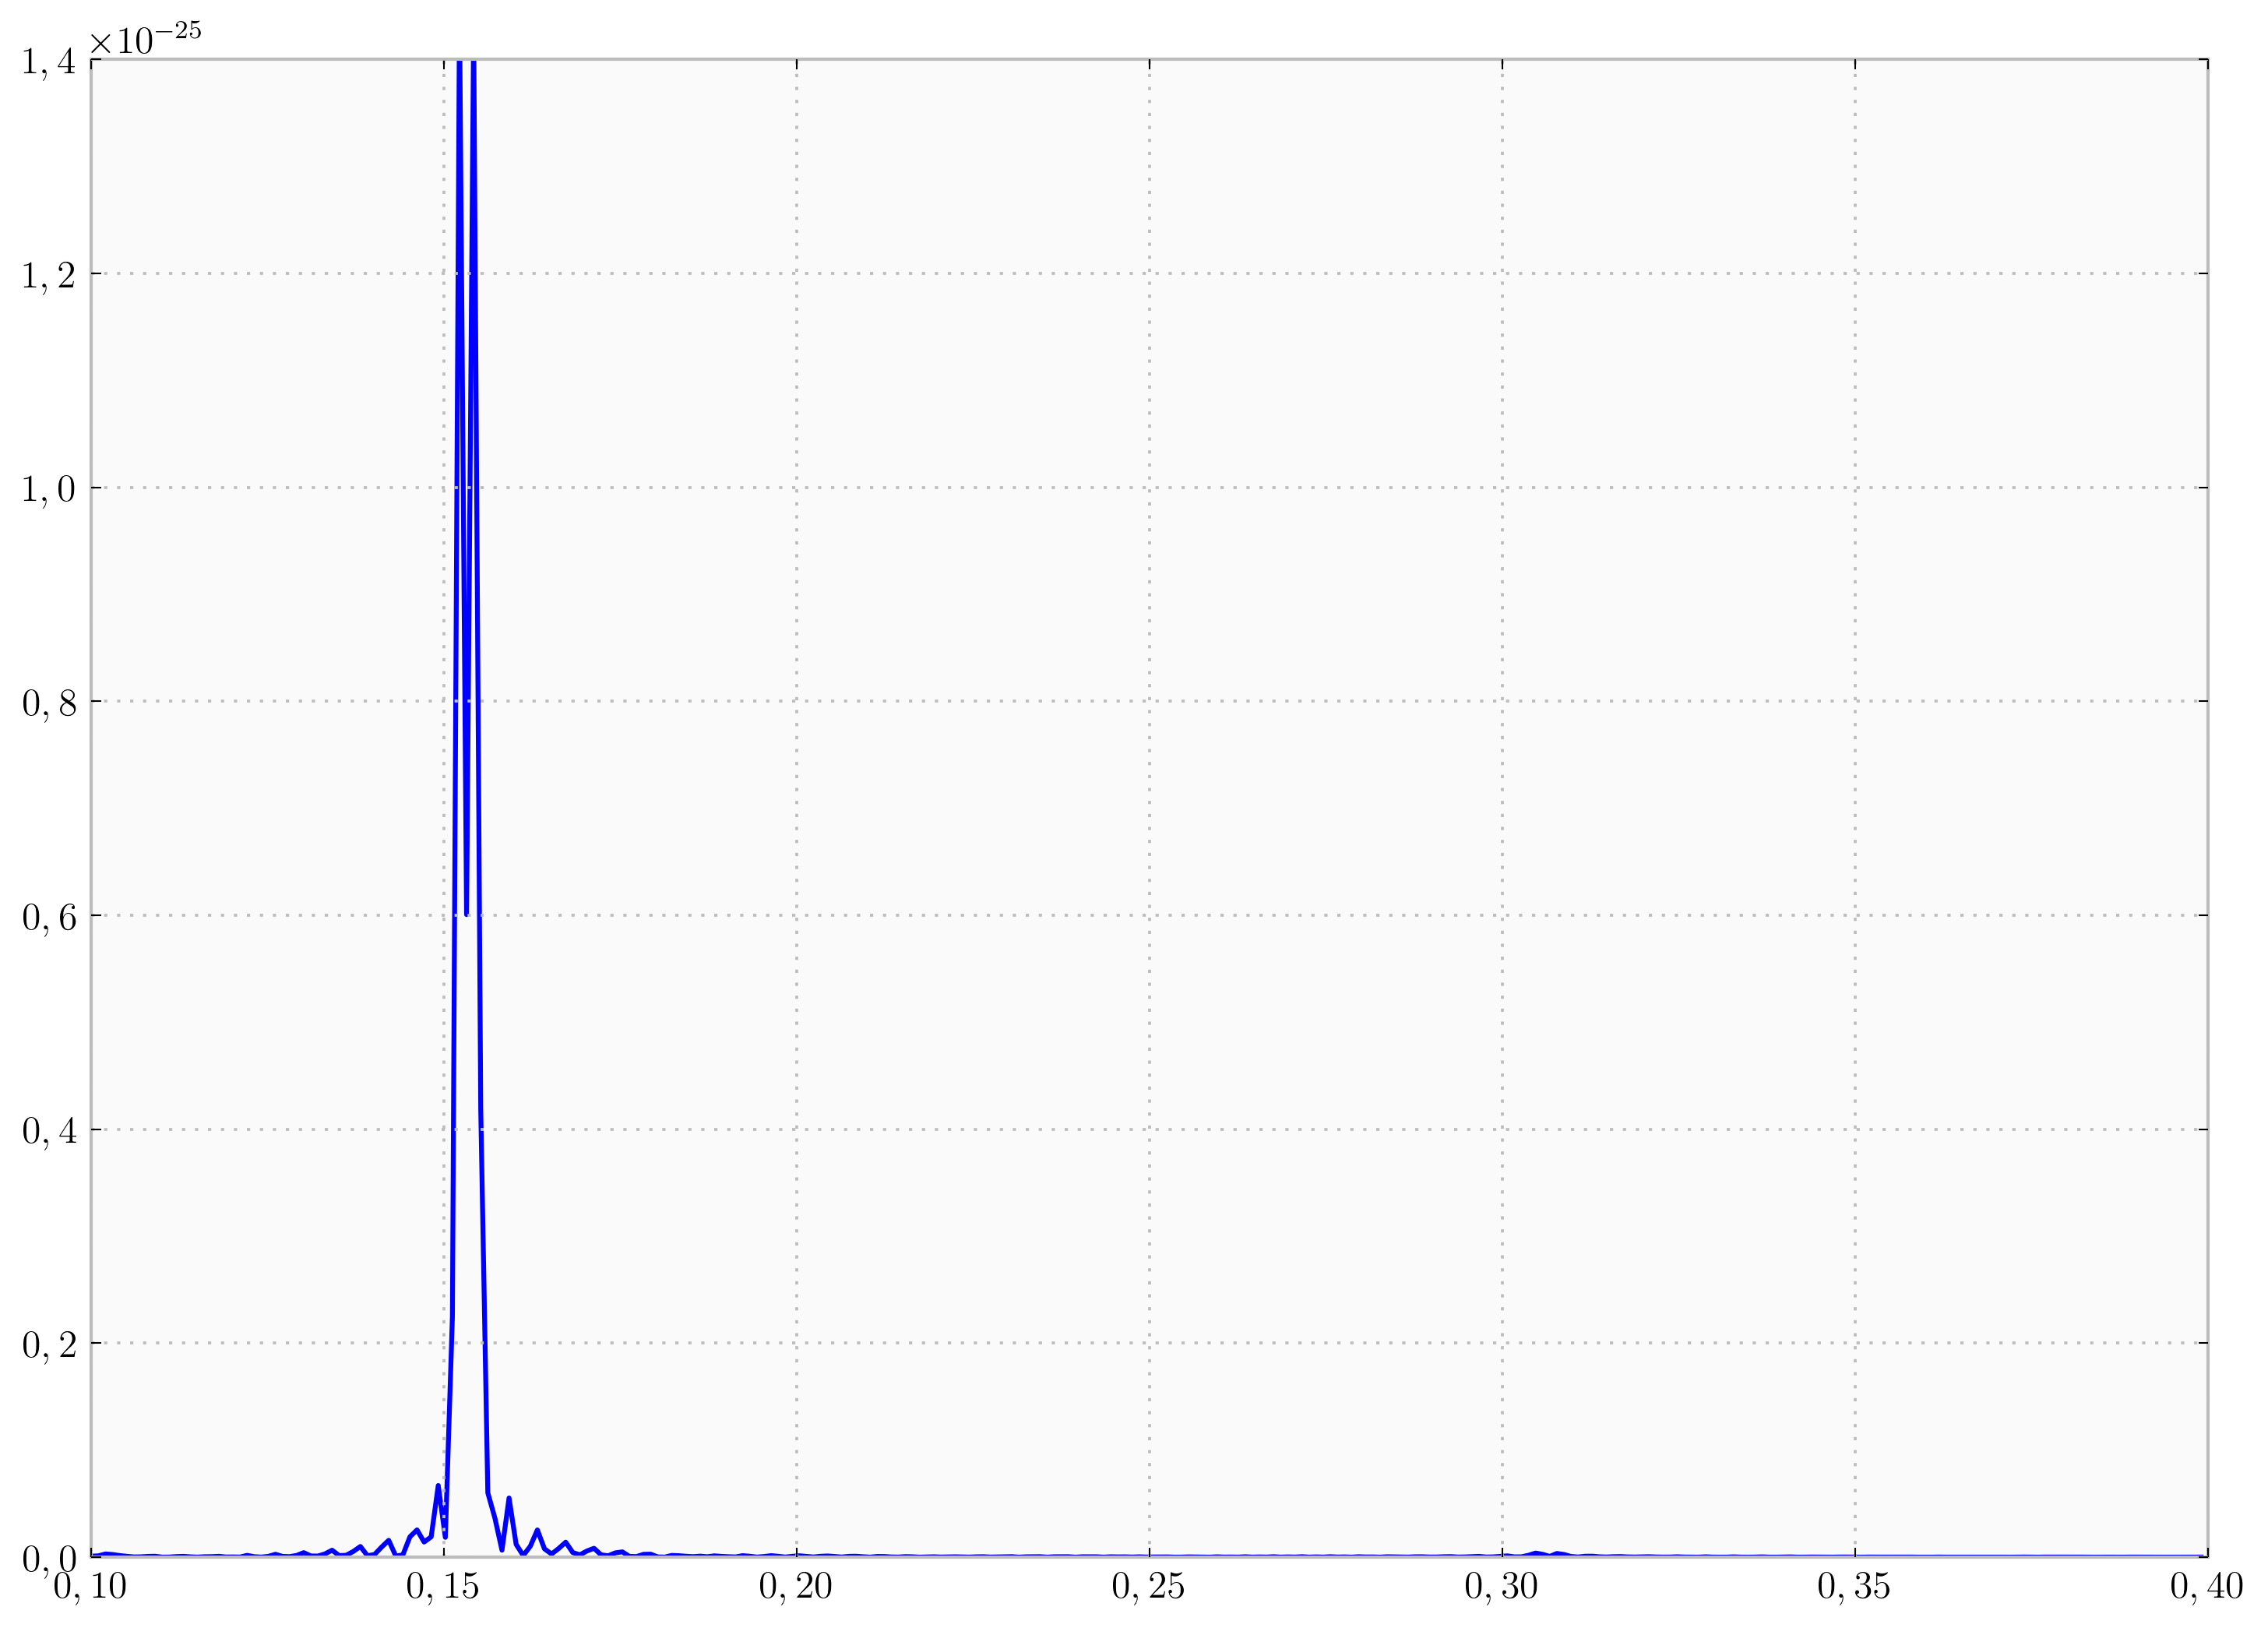

In [24]:
plt.plot(energy, energy*(np.abs(d1i)+np.abs(d2i)))
plt.show()